# Time Series Style Transfer

In [38]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from configs.SimulatedData import Proposed
from dataset.tf_pipeline import make_train_valid_dset
from datetime import datetime
import io
import json
import os
from utils.metric import signature_on_batch, signature_metric
import mlflow
from sklearn.decomposition import PCA
from tensorflow.keras import layers



gpus = tf.config.list_physical_devices('GPU')

if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs.
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized.
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [39]:
config = Proposed()
date_str = datetime.now().strftime('%Y-%m-%d_%H_%M_%S')

CONTENT_DATASET_PATH = "data/simulated_dataset/01 - Source Domain.h5"
STYLE_DATASET_PATHS = ["data/simulated_dataset/output_noise/0.25.h5", "data/simulated_dataset/output_noise/0.75.h5"]

EXPERIMENT_NAME = f"{date_str} - Style Transfer Algorithm"
SAVE_FOLDER = f"experiments_logs/{EXPERIMENT_NAME}"

SEQUENCE_LENGTH = config.sequence_lenght_in_sample
GRANUARITY = config.granularity
OVERLAP = config.overlap
BS = 20 # config.batch_size
VALID_BATCH_SIZE = 50
EPOCHS = 50 # config.epochs
NUM_SEQUENCE_TO_GENERATE = config.met_params.sequence_to_generate
N_SIGNAL= 7
N_CLASSES = 2

STYLE_VECTOR_SIZE = 16
FEAT_WIENER = 2
N_SAMPLE_WIENER = SEQUENCE_LENGTH//4
NOISE_DIM= (N_SAMPLE_WIENER, FEAT_WIENER)
N_VALIDATION_SEQUENCE = 500
DISCR_STEP = 5
DISCR_THREASOLD = 0.9

L_STYLE_GENERATION= 0.01
L_RECONSTR= 0.5



L_CONTENT= 1
L_DIS= 1
TRIPLET_R = 1
L_TRIPLET= 1
L_REALNESS= 0.05
L_ADV=  0.05

L_LOCAL = 0.1
L_GLOBAL = 0.1


BASE_DIR = f"logs - final algo/{EXPERIMENT_NAME}"
TRAIN_LOGS_DIR_PATH = f"{BASE_DIR}/train"
VALID_LOGS_DIR_PATH = f"{BASE_DIR}/valid"
GENERATION_LOG = f"{BASE_DIR}/Generations"
os.makedirs(GENERATION_LOG)
os.makedirs(SAVE_FOLDER)

In [40]:
# server_ip = "192.168.210.102"
# mlflow_port_number= "5001"

# mlflow.set_tracking_uri(f'http://{server_ip}:{mlflow_port_number}') 
# exp = mlflow.get_experiment_by_name("Style Transfer Algorithm")

# run = mlflow.start_run(run_name=date_str) 
# mlflow.tensorflow.autolog()



In [41]:
def save_configuration():
    d = {
        "content_dataset":CONTENT_DATASET_PATH,
        "style_datasets":STYLE_DATASET_PATHS,
        "SEQUENCE_LENGTH":SEQUENCE_LENGTH,
        "granularity":GRANUARITY,
        "overlap":OVERLAP,
        "epochs":EPOCHS,
        "batch_size":BS,
        "style_vector_size":STYLE_VECTOR_SIZE,
        "feat_wiener":FEAT_WIENER,
        "n_sample_wiener":N_SAMPLE_WIENER,
        "triplet_r":TRIPLET_R,
        "n_validation_sequence":N_VALIDATION_SEQUENCE,
        "l_style":L_STYLE_GENERATION,
        "l_content":L_CONTENT,
        "l_triplet":L_TRIPLET,
        "l_realness":L_REALNESS,
        "l_adv":L_ADV,
        "l_reconstr":L_RECONSTR,    
        "log_dir":BASE_DIR
    }

    json_object = json.dumps(d)
    mlflow.log_params({
        "SEQUENCE_LENGTH":SEQUENCE_LENGTH,
        "granularity":GRANUARITY,
        "overlap":OVERLAP,
        "epochs":EPOCHS,
        "batch_size":BS,
        "style_vector_size":STYLE_VECTOR_SIZE,
        "feat_wiener":FEAT_WIENER,
        "n_sample_wiener":N_SAMPLE_WIENER,
        "triplet_r":TRIPLET_R,
        "l_style":L_STYLE_GENERATION,
        "l_content":L_CONTENT,
        "l_triplet":L_TRIPLET,
        "l_realness":L_REALNESS,
        "l_adv":L_ADV,
        "l_reconstr":L_RECONSTR,
    })

    with open(f"{SAVE_FOLDER}/parameters.json", "w") as outfile:
        outfile.write(json_object)


save_configuration()

# Load the Datasets

In [42]:
def train_valid_split(df, train_size:float=.7):
    dset_size = df.shape[0]
    train_index = int(dset_size* train_size)

    train_split = df.loc[:train_index]
    valid_split = df.loc[train_index:]

    return train_split, valid_split

In [43]:
def pd_to_tf_dset(df_path:str, train_batch_size:int=BS, valid_batch_size:int=VALID_BATCH_SIZE):
    _df= pd.read_hdf(df_path).astype(np.float32)
    _df = _df.drop(columns=['labels'])

    content_train, content_valid = make_train_valid_dset(
        _df, 
        SEQUENCE_LENGTH, 
        GRANUARITY, 
        int(OVERLAP* SEQUENCE_LENGTH),
        train_batch_size,
        valid_batch_size,
        reduce_train_set=True
    )

    return content_train, content_valid


def make_style_dataset(train_batch_size:int=BS, valid_batch_size:int=VALID_BATCH_SIZE):
    style_train_datasets, style_valid_datasets = [], []

    for s_i, style_path in enumerate(STYLE_DATASET_PATHS):
        dset_style_train, dset_style_valid = pd_to_tf_dset(style_path, train_batch_size)

        dset_style_train = dset_style_train.map(lambda batch: (batch, tf.zeros(batch.shape[0])+ s_i)).cache()
        dset_style_valid = dset_style_valid.map(lambda batch: (batch, tf.zeros(batch.shape[0])+ s_i)).cache()

        dset_style_train = dset_style_train.unbatch()
        dset_style_valid = dset_style_valid.unbatch()
    
        style_train_datasets.append(dset_style_train)
        style_valid_datasets.append(dset_style_valid)

    style_dset_train = tf.data.Dataset.sample_from_datasets(style_train_datasets).batch(train_batch_size, drop_remainder=True)
    style_dset_valid = tf.data.Dataset.sample_from_datasets(style_valid_datasets).batch(valid_batch_size, drop_remainder=True)

    return style_dset_train, style_dset_valid


In [44]:
content_dset_train, content_dset_valid = pd_to_tf_dset(CONTENT_DATASET_PATH, BS*2, VALID_BATCH_SIZE*2)
style1_dset_train, style1_dset_valid = pd_to_tf_dset(STYLE_DATASET_PATHS[0], BS, VALID_BATCH_SIZE)
style2_dset_train, style2_dset_valid = pd_to_tf_dset(STYLE_DATASET_PATHS[1], BS, VALID_BATCH_SIZE)
# style_dset_train, style_dset_valid = make_style_dataset(BS, VALID_BATCH_SIZE)

[+] Reducing Train set size...
[+] Reducing Train set size...
[+] Reducing Train set size...


In [45]:
next(iter(style2_dset_valid)).shape

TensorShape([50, 64, 7])

## Make Content Encoder

In [46]:
# Define AdaIN Layers for Time Series
class AdaIN(tf.keras.layers.Layer):
    def __init__(self):
        super(AdaIN, self).__init__()

    def get_mean_std(self, x, eps=1e-5):
        _mean, _variance = tf.nn.moments(x, axes=[1], keepdims=True)
        standard_dev = tf.sqrt(_variance+ eps)
        return _mean, standard_dev

    def call(self, content_input, style_input):
        # print(content_input.shape, style_input.shape)
        content_mean, content_std = self.get_mean_std(content_input)
        style_mean, style_std = self.get_mean_std(style_input)
        adain_res =style_std* (content_input - content_mean) / content_std+ style_mean
        return adain_res

### COSCIGAN Generator

In [47]:
def generator_part(content_input, n_sample_wiener:int, feat_wiener:int, style_input):
    init = tf.keras.initializers.RandomNormal()

    # Make a small projection...
    _content_input = tf.keras.layers.Flatten()(content_input)
    _content_input = tf.keras.layers.Dense(n_sample_wiener* feat_wiener, kernel_initializer=init)(_content_input)
    _content_input = tf.keras.layers.Reshape((n_sample_wiener, feat_wiener))(_content_input)

    # Make the style input 
    _style_input = tf.keras.layers.Dense(16)(style_input)
    _style_input = tf.keras.layers.Reshape((16, 1))(_style_input)

    _stage2_style_input = tf.keras.layers.Dense(32)(style_input)
    _stage2_style_input = tf.keras.layers.Reshape((32, 1))(_stage2_style_input)

    x = AdaIN()(_content_input, _style_input)

    x = tf.keras.layers.Conv1DTranspose(16, 5, 1, padding='same', kernel_initializer=init)(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv1DTranspose(16, 5, 2, padding='same', kernel_initializer=init)(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = AdaIN()(x, _stage2_style_input)
    x = tf.keras.layers.Conv1DTranspose(32, 5, 1, padding='same', kernel_initializer=init)(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv1DTranspose(1, 5, 2, padding='same', kernel_initializer=init)(x)
    x = tf.keras.layers.LeakyReLU()(x)

    return x

def make_generator(n_sample_wiener:int, feat_wiener:int, style_vector_size:int, n_generators:int):
    
    input = tf.keras.Input((n_sample_wiener, feat_wiener), name=f"Content_Input")
    style_input = tf.keras.Input((style_vector_size,), name="Style_Input") 
    gens_outputs = []

    for _ in range(n_generators):
        gens_outputs.append(generator_part(input, n_sample_wiener, feat_wiener, style_input))

    test = tf.keras.layers.concatenate(gens_outputs, axis=-1)

    model = tf.keras.Model([input, style_input], test)

    return model

### Discriminators

In [48]:
def make_global_discriminator(seq_length:int, n_signals:int, n_classes:int):
    _input = tf.keras.Input((seq_length, n_signals))

    x = tf.keras.layers.Conv1D(32, 5, 2, padding='same')(_input)
    x = layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv1D(32, 5, 2, padding='same')(x)
    x = layers.LeakyReLU()(x)

    x = layers.Flatten()(x)

    _output = layers.Dense(1, activation="sigmoid")(x)
    _class_output = layers.Dense(n_classes, activation="sigmoid")(x)

    model = tf.keras.Model(_input, [_output, _class_output], name="global_discriminator")
    early_predictor = tf.keras.Model(_input, x, name="early_discriminator")

    return model, early_predictor


def local_discriminator_part(_input, n_classes:int):

    x = tf.keras.layers.Conv1D(16, 5, 2, padding='same')(_input)
    x = layers.LeakyReLU()(x)

    stage1_flatened = layers.Flatten()(_input)
    stage1_dropouted = layers.Dropout(0.25)(stage1_flatened)

    

    x = tf.keras.layers.Conv1D(32, 5, 2, padding='same')(x)
    x = layers.LeakyReLU()(x)

    x = layers.Flatten()(x)

    _output = layers.Dense(1, activation="sigmoid")(x)
    _class_output = layers.Dense(n_classes, activation="sigmoid")(stage1_dropouted)

    return _output, _class_output


def create_local_discriminator(n_signals:int, sequence_length:int, n_styles:int):
    sig_inputs = tf.keras.Input((sequence_length, n_signals))
    splited_inputs = tf.split(sig_inputs, n_signals, axis=-1)

    crit_outputs = []
    style_outputs = []

    for sig_input in splited_inputs:
        crit_output, style_output = local_discriminator_part(sig_input, n_styles)
        crit_outputs.append(crit_output)
        style_outputs.append(style_output)

    crit_outputs = tf.keras.layers.concatenate(crit_outputs, axis=-1, name="crit_output")

    model_output = [crit_outputs]
    model_output.extend(style_outputs)

    return tf.keras.Model(sig_inputs, model_output)

In [49]:
def make_content_encoder(seq_length:int, n_feat:int, feat_wiener:int):
    init = tf.keras.initializers.RandomNormal(seed=42)

    _input = tf.keras.Input((seq_length, n_feat))

    x = tf.keras.layers.Conv1D(64, 5, 2, padding='same', kernel_initializer=init)(_input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
        
    x = tf.keras.layers.Conv1D(128, 5, 1, padding='same', kernel_initializer=init)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    
    x = tf.keras.layers.Conv1D(128, 5, 2, padding='same', kernel_initializer=init)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    
    x = tf.keras.layers.Conv1D(feat_wiener, 5, 1, padding='same', kernel_initializer=init, activation="linear")(x)

    model = tf.keras.Model(_input, x)
    return model

def make_style_encoder(seq_length:int, n_feat:int, vector_output_shape:int):
    init = tf.keras.initializers.RandomNormal(seed=42)

    _input = tf.keras.Input((seq_length, n_feat))

    x = tf.keras.layers.Conv1D(64, 5, 2, padding='same', kernel_initializer=init)(_input) 
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv1D(128, 5, 1, padding='same', kernel_initializer=init)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv1D(128, 5, 2, padding='same', kernel_initializer=init)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv1D(256, 5, 1, padding='same', kernel_initializer=init)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation=None)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dense(vector_output_shape, activation="linear")(x)

    model = tf.keras.Model(_input, x)
    return model


/home/henri/anaconda3/envs/tf2/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


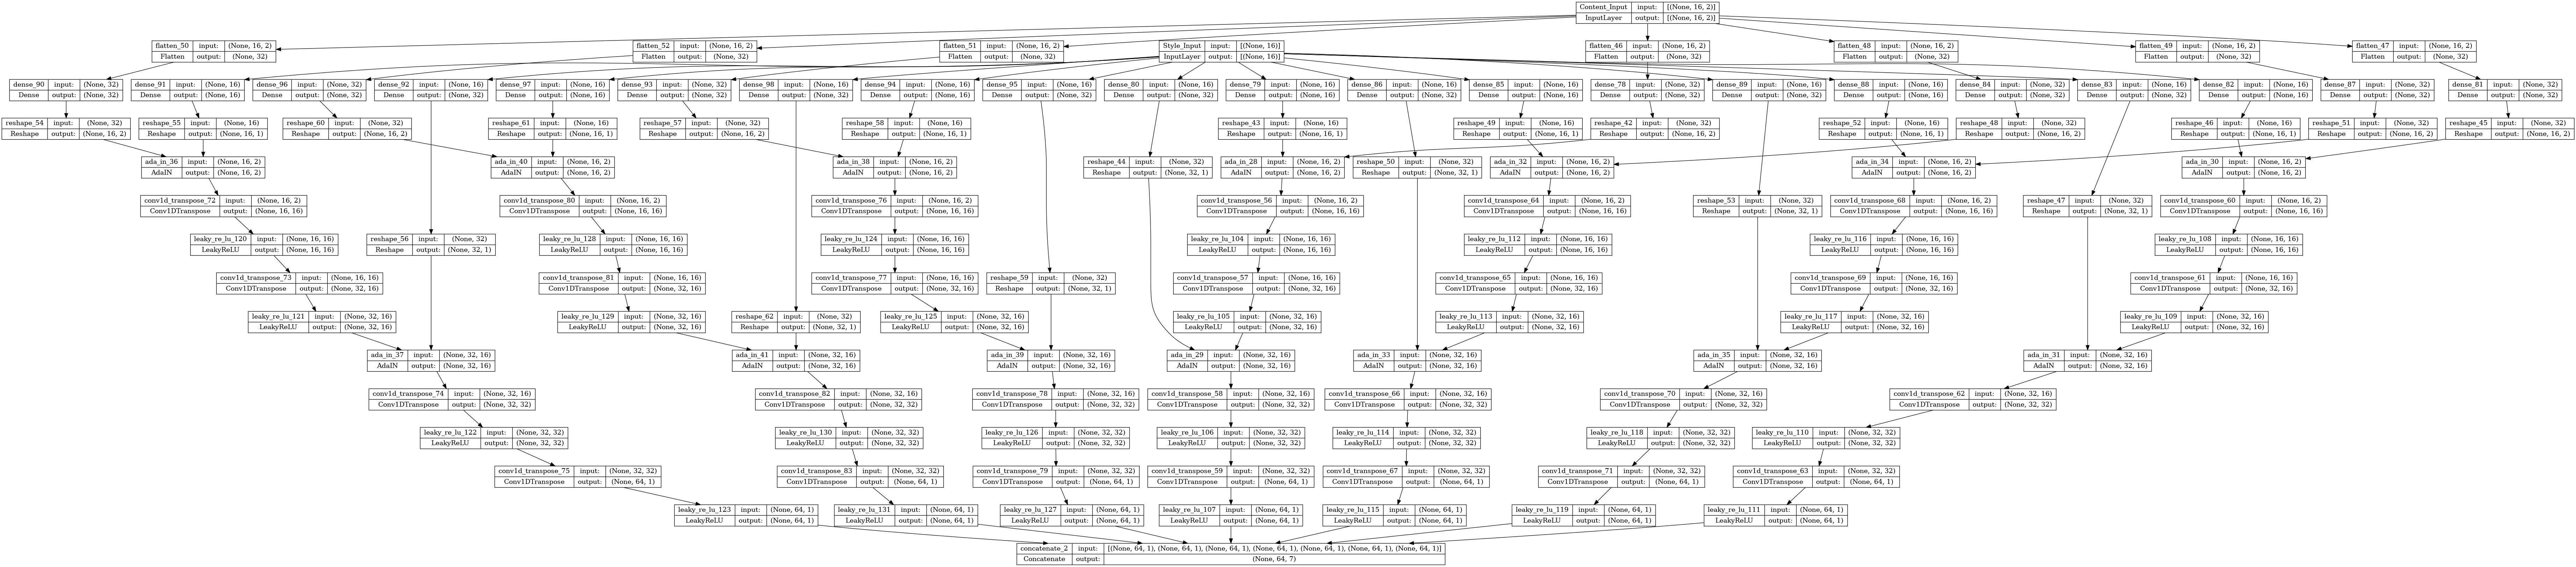

In [50]:
decoder = make_generator(N_SAMPLE_WIENER, FEAT_WIENER, STYLE_VECTOR_SIZE, N_SIGNAL)
# tf.keras.utils.plot_model(decoder, show_shapes=True, to_file='decoder.png')
decoder.count_params()
tf.keras.utils.plot_model(decoder, show_shapes=True)

In [51]:
content_encoder = make_content_encoder(SEQUENCE_LENGTH, N_SIGNAL, FEAT_WIENER)
# tf.keras.utils.plot_model(content_encoder, show_shapes=True, to_file='content_encoder.png')
# content_encoder.summary()

In [52]:
style_encoder = make_style_encoder(SEQUENCE_LENGTH, N_SIGNAL, STYLE_VECTOR_SIZE)
# tf.keras.utils.plot_model(style_encoder, show_shapes=True, to_file='style_encoder.png')
# style_encoder.summary()

In [53]:
global_discriminator = make_global_discriminator(SEQUENCE_LENGTH, N_SIGNAL, N_CLASSES)
# global_discriminator.summary()


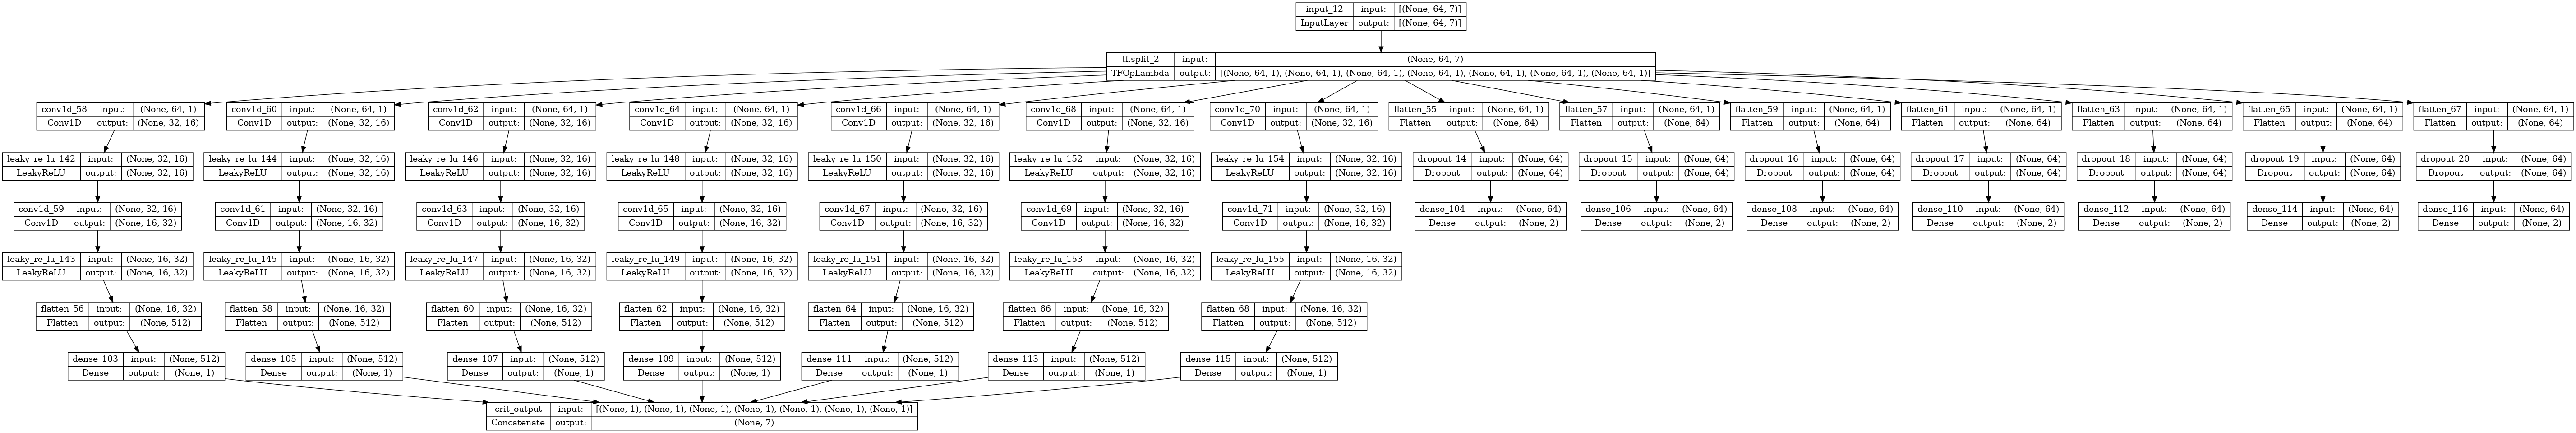

In [54]:
local_discriminator = create_local_discriminator(N_SIGNAL, SEQUENCE_LENGTH, N_CLASSES)
tf.keras.utils.plot_model(local_discriminator, show_shapes=True, to_file='local_discriminator.png')


In [55]:
def generate(content_batch, style_batch):
    content = content_encoder(content_batch, training=False)
    style = style_encoder(style_batch, training=False)
    generated = decoder([content, style], training=False)
    return generated

In [56]:
def get_batches(dset, n_batches):
    _arr = np.array([c for c in dset.take(n_batches)])
    return _arr.reshape((-1, _arr.shape[-2], _arr.shape[-1]))

In [57]:
valid_seed_content = next(iter(content_dset_valid))
valid_seed_style = next(iter(style1_dset_valid))

train_seed_content = next(iter(content_dset_train))
train_seed_style = next(iter(style1_dset_train))

generated_sequence = generate(valid_seed_content[:int(VALID_BATCH_SIZE)], valid_seed_style)

In [58]:
def filter_prediction(x, threashold=.5):
    return tf.cast(x > threashold, tf.float32)* x

In [59]:
# Make seed sequence for particular style.

# train_dset_s1, valid_dset_s1 = pd_to_tf_dset(STYLE_DATASET_PATHS[0])
# train_dset_s2, valid_dset_s2 = pd_to_tf_dset(STYLE_DATASET_PATHS[1])

# content_dset_train, content_dset_valid
# style1_dset_train, style1_dset_valid
# style2_dset_train, style2_dset_valid

seed_content_train = get_batches(content_dset_train, 25)
seed_content_valid = get_batches(content_dset_valid, 25)

seed_style1_train = get_batches(style1_dset_train, 50)
seed_style1_valid = get_batches(style1_dset_valid, 50)

seed_style2_train = get_batches(style2_dset_train, 50)
seed_style2_valid = get_batches(style2_dset_valid, 50)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


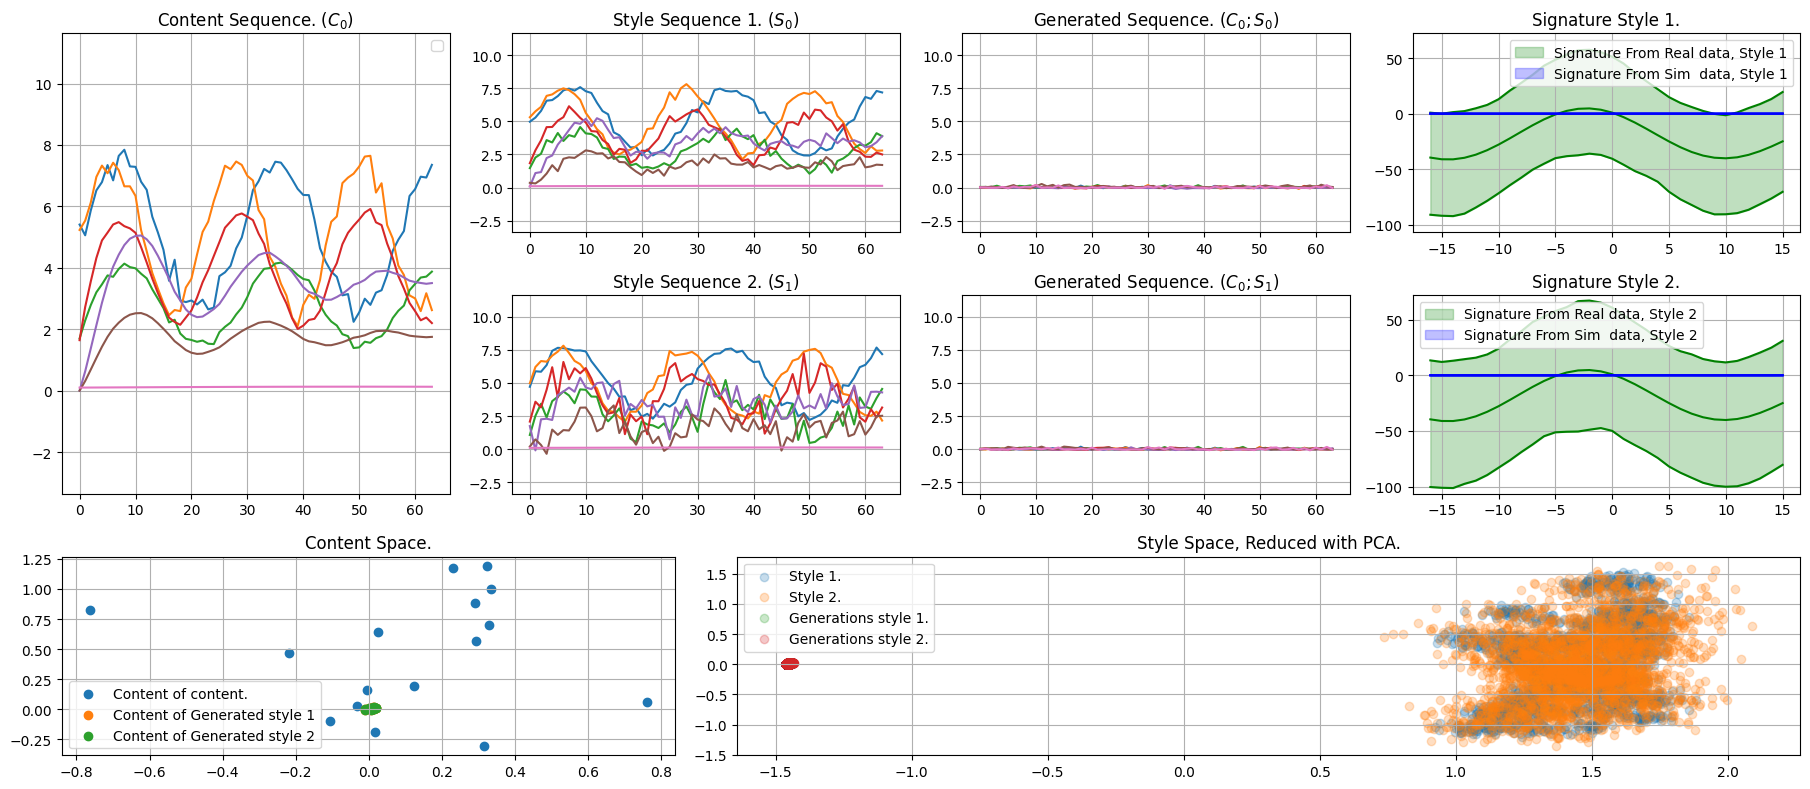

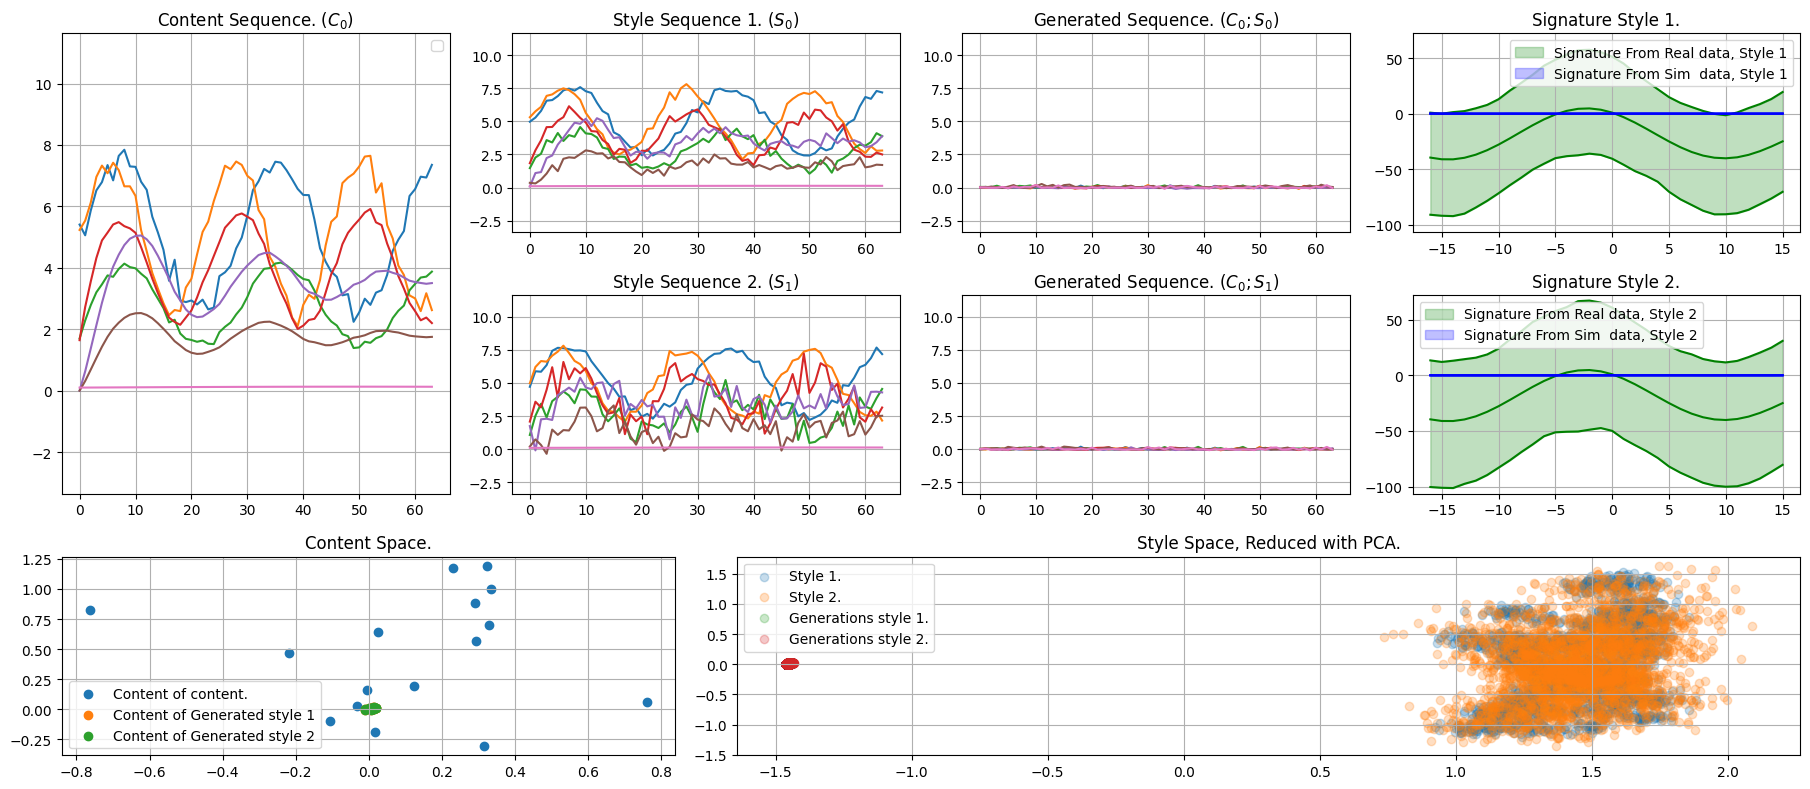

In [60]:
def plot_generated_sequence2(content_sequences, style1_sequences, style2_sequences, show=False):

    # Make Generated sequence for visualization.
    content_of_content = content_encoder(content_sequences, training=False)
    style_of_style1= style_encoder(style1_sequences, training=False)
    style1_generated = decoder([content_of_content, style_of_style1], training=False)

    style_of_style2 = style_encoder(style2_sequences, training=False)
    style2_generated = decoder([content_of_content, style_of_style2], training=False)

    c_style1_generated = content_encoder(style1_generated, training=False)
    s_style1_generated = style_encoder(style1_generated, training=False)

    c_style2_generated = content_encoder(style2_generated, training=False)
    s_style2_generated = style_encoder(style2_generated, training=False)

    style1_signature = signature_on_batch(style1_sequences, config.met_params.ins, config.met_params.outs, config.met_params.signature_length)
    style2_signature = signature_on_batch(style2_sequences, config.met_params.ins, config.met_params.outs, config.met_params.signature_length)
    gen_s1_signature = signature_on_batch(style1_generated, config.met_params.ins, config.met_params.outs, config.met_params.signature_length)
    gen_s2_signature = signature_on_batch(style2_generated, config.met_params.ins, config.met_params.outs, config.met_params.signature_length)

    x = np.arange(style1_signature.shape[1]) - style1_signature.shape[1]/2

    averaged_rs1_sig = np.mean(style1_signature, axis=0)
    averaged_rs2_sig = np.mean(style2_signature, axis=0)
    averaged_gs1_sig = np.mean(gen_s1_signature, axis=0)
    averaged_gs2_sig = np.mean(gen_s2_signature, axis=0)

    sig_mins = np.min([averaged_rs1_sig, averaged_rs2_sig, averaged_gs1_sig, averaged_gs2_sig])- 5
    sig_max = np.max([averaged_rs1_sig, averaged_rs2_sig, averaged_gs1_sig, averaged_gs2_sig]) +5

    
    # Reduce the Style Vector for visualization purposes.
    pca = PCA(2)
    style_vectors = np.vstack(
        [   style_of_style1, 
            style_of_style2, 
            s_style1_generated, 
            s_style2_generated
        ])

    pca.fit(style_vectors)

    reduced_style1 = pca.transform(style_of_style1)
    reduced_style2 = pca.transform(style_of_style2)
    reduced_style1_generated = pca.transform(s_style1_generated)
    reduced_style2_generated = pca.transform(s_style2_generated)


    all_values = np.array([content_sequences, style1_sequences, style2_sequences])
    _min, _max = np.min(all_values)-1, np.max(all_values)+ 1

    fig= plt.figure(figsize=(18, 8))
    spec= fig.add_gridspec(3, 8)

    ax00 = fig.add_subplot(spec[0:2, :2])
    ax00.set_title('Content Sequence. ($C_0$)')
    ax00.plot(content_sequences[0])
    ax00.set_ylim(_min, _max)
    ax00.grid(True)
    ax00.legend()

# #######
    ax01 = fig.add_subplot(spec[0, 2:4])
    ax01.set_title('Style Sequence 1. ($S_0$)')
    ax01.plot(style1_sequences[0])
    ax01.set_ylim(_min, _max)
    ax01.grid(True)

    ax11 = fig.add_subplot(spec[1, 2:4])
    ax11.set_title("Style Sequence 2. ($S_1$)")
    ax11.plot(style2_sequences[0])
    ax11.set_ylim(_min, _max)
    ax11.grid(True)

# #######
    ax02 = fig.add_subplot(spec[0, 4:6])
    ax02.set_title('Generated Sequence. ($C_0; S_0$)')
    ax02.plot(style1_generated[0])
    ax02.set_ylim(_min, _max)
    ax02.grid(True) 

    ax12 = fig.add_subplot(spec[1, 4:6])
    ax12.set_title('Generated Sequence. ($C_0; S_1$)')
    ax12.plot(style2_generated[1])
    ax12.set_ylim(_min, _max)
    ax12.grid(True) 

# #####

    ax03 = fig.add_subplot(spec[0, 6:])
    ax03.set_title("Signature Style 1.")


    plt.plot(x, averaged_rs1_sig[:, 0], "g")
    plt.plot(x, averaged_rs1_sig[:, 1], "g")
    plt.plot(x, averaged_rs1_sig[:, 2], "g")

    plt.plot(x, averaged_gs1_sig[:, 0], "b")
    plt.plot(x, averaged_gs1_sig[:, 1], "b")
    plt.plot(x, averaged_gs1_sig[:, 2], "b")


    plt.fill_between(x, averaged_rs1_sig[:, 0].reshape((-1,)), averaged_rs1_sig[:, 1].reshape((-1,)), color="g", alpha=0.25, label="Signature From Real data, Style 1")
    plt.fill_between(x, averaged_gs1_sig[:, 0].reshape((-1,)), averaged_gs1_sig[:, 1].reshape((-1,)), color="b", alpha=0.25, label="Signature From Sim  data, Style 1")

    ax03.set_ylim(sig_mins, sig_max)
    ax03.grid(True)
    ax03.legend()
    

    ax04 = fig.add_subplot(spec[1, 6:])
    ax04.set_title("Signature Style 2.")

    plt.plot(x, averaged_rs2_sig[:, 0], "g")
    plt.plot(x, averaged_rs2_sig[:, 1], "g")
    plt.plot(x, averaged_rs2_sig[:, 2], "g")

    plt.plot(x, averaged_gs2_sig[:, 0], "b")
    plt.plot(x, averaged_gs2_sig[:, 1], "b")
    plt.plot(x, averaged_gs2_sig[:, 2], "b")

    plt.fill_between(x, averaged_rs2_sig[:, 0].reshape((-1,)), averaged_rs2_sig[:, 1].reshape((-1,)), color="g", alpha=0.25, label="Signature From Real data, Style 2")
    plt.fill_between(x, averaged_gs2_sig[:, 0].reshape((-1,)), averaged_gs2_sig[:, 1].reshape((-1,)), color="b", alpha=0.25, label="Signature From Sim  data, Style 2")

    ax04.grid(True)
    ax04.set_ylim(sig_mins, sig_max)
    ax04.legend()


# #####
    ax10 = fig.add_subplot(spec[2, :3])
    ax10.set_title('Content Space.')
    ax10.scatter(content_of_content[0, :, 0], content_of_content[0, :, 1],  label='Content of content.')
    ax10.scatter(c_style1_generated[0, :, 0], c_style1_generated[0, :, 1], label='Content of Generated style 1')
    ax10.scatter(c_style2_generated[0, :, 0], c_style2_generated[0, :, 1],  label='Content of Generated style 2')
    ax10.grid(True)
    ax10.legend()

    ax11 = fig.add_subplot(spec[2, 3:])
    ax11.set_title('Style Space, Reduced with PCA.')
    ax11.scatter(reduced_style1[:, 0], reduced_style1[:, 1], label='Style 1.', alpha=0.25)
    ax11.scatter(reduced_style2[:, 0], reduced_style2[:, 1], label='Style 2.', alpha=0.25)
    ax11.scatter(reduced_style1_generated[:, 0], reduced_style1_generated[:, 1], label='Generations style 1.', alpha=0.25)
    ax11.scatter(reduced_style2_generated[:, 0], reduced_style2_generated[:, 1], label='Generations style 2.', alpha=0.25)

    ax11.grid(True)
    ax11.legend()

    plt.tight_layout()

    return fig

plot_generated_sequence2(seed_content_valid, seed_style1_valid, seed_style2_valid)

In [61]:
def fig_to_buff(fig):
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    plt.close(fig)
    return buf

## Define losses.

In [62]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
error_classif = tf.keras.losses.SparseCategoricalCrossentropy()

def recontruction_loss(true:tf.Tensor, generated:tf.Tensor):
    diff = generated- true
    result = tf.math.reduce_mean(tf.square(diff))
    return result

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


def fixed_point_content(encoded_content_real, encoded_content_fake):
    diff = encoded_content_fake- encoded_content_real
    return tf.reduce_mean(tf.square(diff))

def style_classsification_loss(y_pred, y_true):
    return error_classif(y_true, y_pred)

## Tensorboard Logs.

In [63]:
# Train Metrics
# Generator Losses
met_generator_train = tf.keras.metrics.Mean(name="Total Generator Loss")

met_generator_reconstruction_train = tf.keras.metrics.Mean(name="Generator Reconstruction Loss")

met_generator_local_realness_train = tf.keras.metrics.Mean(name="Generator local Realness loss Train")
met_generator_global_realness_train = tf.keras.metrics.Mean(name="Generator Global Realness loss Train")

# Style Encoder Loss
met_triplet_train = tf.keras.metrics.Mean(name="Total Triplet Loss")
met_disentanglement_train = tf.keras.metrics.Mean(name="Disentanglement Loss")
met_style_encoder_train = tf.keras.metrics.Mean(name="Style Loss")

# Content encoder Loss
met_content_encoder_train= tf.keras.metrics.Mean(name="Content Encoder Loss")

# Central Discriminator
met_central_d_train= tf.keras.metrics.Mean(name="Central Discriminator Loss")
met_central_d_style_real_train = tf.keras.metrics.Mean(name="Central Discriminator Loss Real Style Classif")
met_central_d_style_fake_train = tf.keras.metrics.Mean(name="Central Discriminator Loss Fake Style Classif")

# Channel Discriminator.
met_channel_d_train= tf.keras.metrics.Mean(name="Channel Discriminator Loss")
met_channel_d_style_real_train = tf.keras.metrics.Mean(name="Channel Discriminator Real Style Classification")
met_channel_d_style_fake_train = tf.keras.metrics.Mean(name="Channel Discriminator Fake Style Classification")

# Correlation Metric
met_corr_style1_train = tf.keras.metrics.Mean(name="Correlation Metric Style 1")
met_corr_style2_train = tf.keras.metrics.Mean(name="Correlation Metric Style 2")


# Valid Metrics
# Generator Metric
met_generator_valid = tf.keras.metrics.Mean(name="Total Generator Loss")

met_generator_reconstruction_valid = tf.keras.metrics.Mean(name="Generator Reconstruction Loss")

met_generator_local_realness_valid = tf.keras.metrics.Mean(name="Generator local Realness loss valid")
met_generator_global_realness_valid = tf.keras.metrics.Mean(name="Generator Global Realness loss valid")

# Style Encoder Loss
met_triplet_valid = tf.keras.metrics.Mean(name="Total Triplet Loss")
met_disentanglement_valid = tf.keras.metrics.Mean(name="Disentanglement Loss")
met_style_encoder_valid = tf.keras.metrics.Mean(name="Style Loss")

# Content encoder Loss
met_content_encoder_valid= tf.keras.metrics.Mean(name="Content Encoder Loss")

# Central Discriminator
met_central_d_valid= tf.keras.metrics.Mean(name="Central Discriminator Loss")
met_central_d_style_real_valid = tf.keras.metrics.Mean(name="Central Discriminator Loss Real Style Classif")
met_central_d_style_fake_valid = tf.keras.metrics.Mean(name="Central Discriminator Loss Fake Style Classif")

# Channel Discriminator.
met_channel_d_valid= tf.keras.metrics.Mean(name="Channel Discriminator Loss")
met_channel_d_style_real_valid = tf.keras.metrics.Mean(name="Channel Discriminator Real Style Classification")
met_channel_d_style_fake_valid = tf.keras.metrics.Mean(name="Channel Discriminator Fake Style Classification")

# Correlation Metric
met_corr_style1_valid = tf.keras.metrics.Mean(name="Correlation Metric Style 1")
met_corr_style2_valid = tf.keras.metrics.Mean(name="Correlation Metric Style 2")

In [64]:
TRAIN_SUMMARY_WRITER = tf.summary.create_file_writer(TRAIN_LOGS_DIR_PATH)
VALID_SUMMARY_WRITER = tf.summary.create_file_writer(VALID_LOGS_DIR_PATH)

def log_train_losses(epoch, plot_buf):
    image = tf.image.decode_png(plot_buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)

    with TRAIN_SUMMARY_WRITER.as_default():
        tf.summary.scalar("00 - Correlation Metric Style 1", met_corr_style1_train.result(), step=epoch)
        tf.summary.scalar("01 - Correlation Metric Style 2", met_corr_style2_train.result(), step=epoch)

        tf.summary.scalar("10 - Total Generator Loss", met_generator_train.result(), step=epoch)
        tf.summary.scalar("11 - Reconstruction from Content", met_generator_reconstruction_train.result(), step=epoch)

        tf.summary.scalar("12 - Central Realness", met_generator_global_realness_train.result(), step=epoch)
        tf.summary.scalar("13 - Local Realness", met_generator_local_realness_train.result(), step=epoch)

        tf.summary.scalar("20 - Style Loss", met_style_encoder_train.result(), step=epoch)
        tf.summary.scalar("21 - Triplet Loss", met_triplet_train.result(), step=epoch)
        tf.summary.scalar("22 - Disentanglement Loss", met_disentanglement_train.result(), step=epoch)

        tf.summary.scalar("30 - Content Loss", met_content_encoder_train.result(), step=epoch)

        tf.summary.scalar("40 - Global Discriminator Loss", met_central_d_train.result(), step=epoch)
        tf.summary.scalar("40 - Local Discriminator Loss", met_channel_d_train.result(), step=epoch)

        tf.summary.scalar("41 - Global Discriminator Style Loss (Real Data)", met_central_d_style_real_train.result(), step=epoch)
        tf.summary.scalar("41 - Global Discriminator Style Loss (Fake Data)", met_central_d_style_fake_train.result(), step=epoch)

        tf.summary.scalar("42 - Local Discriminator Style Loss (Real Data)", met_channel_d_style_real_train.result(), step=epoch)
        tf.summary.scalar("42 - Local Discriminator Style Loss (Fake Data)", met_channel_d_style_fake_train.result(), step=epoch)

        tf.summary.image("Training Generations", image, step=epoch)


def log_valid_losses(epoch):
    with VALID_SUMMARY_WRITER.as_default():
        tf.summary.scalar("00 - Correlation Metric Style 1", met_corr_style1_valid.result(), step=epoch)
        tf.summary.scalar("01 - Correlation Metric Style 2", met_corr_style2_valid.result(), step=epoch)

        tf.summary.scalar("10 - Total Generator Loss", met_generator_valid.result(), step=epoch)
        tf.summary.scalar("11 - Reconstruction from Content", met_generator_reconstruction_valid.result(), step=epoch)

        tf.summary.scalar("12 - Central Realness", met_generator_global_realness_valid.result(), step=epoch)
        tf.summary.scalar("13 - Local Realness", met_generator_local_realness_valid.result(), step=epoch)

        tf.summary.scalar("20 - Style Loss", met_style_encoder_valid.result(), step=epoch)
        tf.summary.scalar("21 - Triplet Loss", met_triplet_valid.result(), step=epoch)
        tf.summary.scalar("22 - Disentanglement Loss", met_disentanglement_valid.result(), step=epoch)

        tf.summary.scalar("30 - Content Loss", met_content_encoder_valid.result(), step=epoch)

        tf.summary.scalar("40 - Global Discriminator Loss", met_central_d_valid.result(), step=epoch)
        tf.summary.scalar("40 - Local Discriminator Loss", met_channel_d_valid.result(), step=epoch)

        tf.summary.scalar("41 - Global Discriminator Style Loss (Real Data)", met_central_d_style_real_valid.result(), step=epoch)
        tf.summary.scalar("41 - Global Discriminator Style Loss (Fake Data)", met_central_d_style_fake_valid.result(), step=epoch)

        tf.summary.scalar("42 - Local Discriminator Style Loss (Real Data)", met_channel_d_style_real_valid.result(), step=epoch)
        tf.summary.scalar("42 - Local Discriminator Style Loss (Fake Data)", met_channel_d_style_fake_valid.result(), step=epoch)
        

def reset_metric_states():
    met_generator_train.reset_states()
    met_generator_reconstruction_train.reset_states()
    met_generator_local_realness_train.reset_states()
    met_generator_global_realness_train.reset_states()
    met_triplet_train.reset_states()
    met_disentanglement_train.reset_states()
    met_style_encoder_train.reset_states()
    met_content_encoder_train.reset_states()
    met_central_d_train.reset_states()
    met_central_d_style_real_train.reset_states()
    met_central_d_style_fake_train.reset_states()
    met_channel_d_train.reset_states()
    met_channel_d_style_real_train.reset_states()
    met_channel_d_style_fake_train.reset_states()
    met_corr_style1_train.reset_states()
    met_corr_style2_train.reset_states()


def reset_valid_states():
    met_generator_valid.reset_states()
    met_generator_reconstruction_valid.reset_states()
    met_generator_local_realness_valid.reset_states()
    met_generator_global_realness_valid.reset_states()
    met_triplet_valid.reset_states()
    met_disentanglement_valid.reset_states()
    met_style_encoder_valid.reset_states()
    met_content_encoder_valid.reset_states()
    met_central_d_valid.reset_states()
    met_central_d_style_real_valid.reset_states()
    met_central_d_style_fake_valid.reset_states()
    met_channel_d_valid.reset_states()
    met_channel_d_style_real_valid.reset_states()
    met_channel_d_style_fake_valid.reset_states()
    met_corr_style1_valid.reset_states()
    met_corr_style2_valid.reset_states()

## Instantiate model for training.

In [65]:
content_encoder = make_content_encoder(SEQUENCE_LENGTH, N_SIGNAL, FEAT_WIENER)
style_encoder = make_style_encoder(SEQUENCE_LENGTH, N_SIGNAL, STYLE_VECTOR_SIZE)
decoder = make_generator(N_SAMPLE_WIENER, FEAT_WIENER, STYLE_VECTOR_SIZE ,N_SIGNAL)
global_discriminator ,_ = make_global_discriminator(SEQUENCE_LENGTH, N_SIGNAL, N_CLASSES)
local_discriminator = create_local_discriminator(N_SIGNAL, SEQUENCE_LENGTH, N_CLASSES)

opt_content_encoder = tf.keras.optimizers.Adam(learning_rate=0.002)
opt_style_encoder = tf.keras.optimizers.Adam(learning_rate=0.002)
opt_decoder = tf.keras.optimizers.Adam(learning_rate=0.002)

local_discriminator_opt = tf.keras.optimizers.Adam(learning_rate=0.002)
global_discriminator_opt = tf.keras.optimizers.Adam(learning_rate=0.002)

# opt_content_encoder = tf.keras.optimizers.RMSprop(learning_rate=1e-4)
# opt_style_encoder = tf.keras.optimizers.RMSprop(learning_rate=1e-4)
# opt_decoder = tf.keras.optimizers.RMSprop(learning_rate=1e-3)
# opt_discr = tf.keras.optimizers.RMSprop(learning_rate=1e-5)

/home/henri/anaconda3/envs/tf2/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


## Train the model

In [66]:
from itertools import product
indexes = np.array(list(product(range(BS), range(BS))))
other_index = np.arange(BS)* BS

In [67]:
anchor_indexes = np.array([ i* BS+i for i in range(BS) for _ in range(BS) ])
pos_indexes = np.array([ BS*j + i for i in range(BS) for j in range(BS)])
neg_indexes = np.array([ (j*BS + (i+1)%BS) for i in range(BS) for j in range(BS)])

In [68]:
def get_style_voctor_for_dis_loss(style_vector:tf.Tensor, batch_size:int):
    anchor_indexes = np.array([ i* batch_size+i for i in range(batch_size) for _ in range(batch_size-1) ])
    return tf.gather(style_vector, anchor_indexes)

def get_anchor_positive_negative_from_batch(style_from_style_ts:tf.Tensor, style_of_generations:tf.Tensor, batch_size:int):
    anchor_indexes = np.array([ i* batch_size+i for i in range(batch_size) for _ in range(batch_size) ])
    pos_indexes = np.array([ batch_size*j + i for i in range(batch_size) for j in range(batch_size)])
    neg_indexes = np.array([ (j*batch_size + (i+1)%batch_size) for i in range(batch_size) for j in range(batch_size)])

    # Anchor are for example:
    # [(c0, s0), (c0, s0), 
    # (c1, s1), (c1, s1), ...]
    anchors = tf.gather(style_from_style_ts, anchor_indexes)
    # Different content, Same Style:
    # [(c1, s0), (c2, s0),(c2, s0),
    #  (c1, s1), (c2, s1), (c3, s1)...]
    # E_s(G(x, y1))
    pos_vector= tf.gather(style_of_generations, pos_indexes)
    # Same content but different style
    # [(c1, s1), (c2, s1),(c2, s1),
    #  (c1, s2), (c2, s2), (c3, s2)...]
    # # E_s(G(x, y2)) 
    neg_vector = tf.gather(style_of_generations, neg_indexes)

    return anchors, pos_vector, neg_vector

def get_dissantanglement_loss_component(style_of_generations, style_of_style, batch_size:int):
    anchor_indexes = np.array([ i* batch_size+i for i in range(batch_size) for _ in range(batch_size-1) ])
    pos_indexes = np.array([ batch_size*j + i for i in range(batch_size) for j in range(batch_size) if i !=j ])

    es_y = tf.gather(style_of_style, anchor_indexes)
    es_x1_y = tf.gather(style_of_generations, anchor_indexes)
    es_x2_y = tf.gather(style_of_generations, pos_indexes)

    return es_y, es_x1_y, es_x2_y


def l2(x:tf.Tensor, y:tf.Tensor):
    diff = tf.square(y- x)
    _distance = tf.reduce_sum(diff, axis=-1)
    return _distance


def fixed_point_content(encoded_content_real, encoded_content_fake):
    diff = l2(encoded_content_real, encoded_content_fake)
    return tf.reduce_mean(diff)

def fixed_point_triplet_style_loss(anchor_encoded_style, positive_encoded_style, negative_encoded_style):
    # shape: [BS, Style_length]
    negative_distance = l2(negative_encoded_style, anchor_encoded_style)
    positive_distance = l2(positive_encoded_style, anchor_encoded_style)

    triplet = TRIPLET_R+ positive_distance- negative_distance
    zeros = tf.zeros_like(triplet)
    triplet = tf.math.maximum(triplet, zeros)

    loss = tf.reduce_mean(triplet)
    return loss

def fixed_point_disentanglement(
        es_x1_y:tf.Tensor, 
        es_x2_y:tf.Tensor, 
        es_y:tf.Tensor
        ):

    diff1 = l2(es_x1_y, es_x2_y)
    diff2 = l2(es_x1_y, es_y)

    loss = diff1- diff2
    zeros = tf.zeros_like(loss)
    loss = tf.math.maximum(loss, zeros)
    loss = tf.reduce_mean(loss)
    return loss


def style_constrain_loss(style_of_style_batch, style_of_generation):
    diff = l2(style_of_style_batch, style_of_generation)
    diff = tf.reduce_mean(diff)
    return diff

In [69]:
bc = tf.keras.losses.BinaryCrossentropy()
error_classif = tf.keras.losses.SparseCategoricalCrossentropy()

def local_discriminator_loss(crits_on_real, crits_on_fake):
    individual_losses = []

    for i in range(crits_on_real.shape[0]):
        l1 = bc(tf.zeros_like(crits_on_real), crits_on_fake[i])
        l2 = bc(tf.ones_like(crits_on_real), crits_on_real[i])
        loss = (l1+ l2)/2
        individual_losses.append(loss)
        
    return individual_losses


def local_generator_loss(crit_on_fake):
    individual_losses = []
    true_label = tf.zeros(crit_on_fake[0].shape)

    for i in range(crit_on_fake.shape[0]):
        individual_losses.append(bc(true_label, crit_on_fake[i]))
        
    return tf.reduce_mean(individual_losses)


def style_classsification_loss(y_pred, y_true):
    return error_classif(y_true, y_pred)


def global_discriminator_loss(crit_on_real, crit_on_fake):
    l1 = bc(tf.zeros_like(crit_on_fake), crit_on_fake)
    l2 = bc(tf.ones_like(crit_on_real), crit_on_real)
    loss = (l1+ l2)/2

    return loss


def global_generator_loss(crit_on_fake):
    loss = bc(tf.ones_like(crit_on_fake), crit_on_fake)
    return loss

In [70]:
def _pairwise_distance(a_embeddings, b_embeddings):
    # Get the dot product between all embeddings
    # shape (batch_size, batch_size)
    dot_product = tf.matmul(a_embeddings, tf.transpose(b_embeddings))

    # Get squared L2 norm for each embedding. We can just take the diagonal of `dot_product`.
    # This also provides more numerical stability (the diagonal of the result will be exactly 0).
    # shape (batch_size,)
    square_norm = tf.linalg.diag_part(dot_product)

    # Compute the pairwise distance matrix as we have:
    # ||a - b||^2 = ||a||^2  - 2 <a, b> + ||b||^2
    # shape (batch_size, batch_size)
    distances = tf.expand_dims(square_norm, 0) - 2.0 * dot_product + tf.expand_dims(square_norm, 1)

    # Because of computation errors, some distances might be negative so we put everything >= 0.0
    distances = tf.maximum(distances, 0.0)

    return distances

def get_positives(labels):
    # will assign 1 where this is a positive 
    positive_mask = np.array([ tf.cast(labels == l, tf.float32) for l in labels])
    positive_mask = positive_mask - np.identity(positive_mask.shape[0])
    return positive_mask

def get_negative(labels):
    neg_labels= np.array([ tf.cast(labels != l, tf.float32) for l in labels])
    return neg_labels


def get_triplet_loss(anchor_embedding, positive_embedding, negative_embedding):
    positive_distance= _pairwise_distance(anchor_embedding, positive_embedding)
    negative_distance= _pairwise_distance(anchor_embedding, negative_embedding)

    positive_index= tf.argmax(positive_distance, axis=1)

    pos_embedding = tf.gather(positive_embedding, positive_index)
 
    neg_indexes = tf.argmin(negative_distance, axis=1)
    
    neg_embeddings= tf.gather(negative_embedding, neg_indexes)

    positive_distances= l2(anchor_embedding, pos_embedding)
    negative_distances= l2(anchor_embedding, neg_embeddings)

    loss = tf.reduce_mean(tf.maximum(TRIPLET_R+ positive_distances - negative_distances, 0))

    return loss

def compute_metric(generated_style:tf.Tensor, true_style:tf.Tensor):
    true_signature = signature_on_batch(true_style, config.met_params.ins, config.met_params.outs, config.met_params.signature_length)
    generated_signature= signature_on_batch(generated_style, config.met_params.ins, config.met_params.outs, config.met_params.signature_length)

    return signature_metric(true_signature, generated_signature)

In [71]:
a = tf.constant([1, 2, 3])

b = tf.stack((a,a))
c = tf.reduce_mean(b, 0)
c

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([1, 2, 3], dtype=int32)>

In [72]:
@tf.function
def discriminator_step(content_sequence1, content_sequence2, style1_sequences, style2_sequences):
    # Discriminator Step
    with tf.GradientTape(persistent=True) as discr_tape:
        # Sequence generations.
        c1 = content_encoder(content_sequence1, training=False)

        s1 = style_encoder(style1_sequences, training=False)
        s2 = style_encoder(style2_sequences, training=False)

        style1_generated= decoder([c1, s1], training=False)
        style2_generated= decoder([c1, s2], training=False)

        # Global on Real
        g_crit_real1, g_style_classif_real1 = global_discriminator(style1_sequences, training=True)
        g_crit_real2, g_style_classif_real2 = global_discriminator(style2_sequences, training=True)

        # Global on Generated
        g_crit_fake1, _ = global_discriminator(style1_generated, training=True)
        g_crit_fake2, _ = global_discriminator(style2_generated, training=True)

        # Local on Real
        l_real1 = local_discriminator(style1_sequences, training=True)
        l_crit1_real, l_style1_real = l_real1[0], l_real1[1:]

        l_real2 = local_discriminator(style2_sequences, training=True)
        l_crit2_real, l_style2_real = l_real2[0], l_real2[1:]

        # Local on fake
        l_fake1 = local_discriminator(style1_generated, training=True)
        l_crit_fake1 = l_fake1[0] # Don't care bout the generated style here.

        l_fake2 = local_discriminator(style2_generated, training=True)
        l_crit_fake2 = l_fake2[0] # Don't care bout the generated style here.

        # Compute the loss for GLOBAL the Discriminator
        g_crit_loss1 = discriminator_loss(g_crit_real1, g_crit_fake1)
        g_crit_loss2 = discriminator_loss(g_crit_real2, g_crit_fake2)

        g_crit_loss = tf.stack((g_crit_loss1, g_crit_loss2))
        g_crit_loss = tf.reduce_mean(g_crit_loss, 0)
        
        style_labels = tf.zeros((BS, 1))
        g_style1_real = style_classsification_loss(g_style_classif_real1, style_labels+ 0.)
        g_style2_real = style_classsification_loss(g_style_classif_real2, style_labels +1.)

        g_style_real = tf.stack((g_style1_real, g_style2_real))
        g_style_real = tf.reduce_mean(g_style_real, 0)

        l_loss1 = local_discriminator_loss(l_crit1_real, l_crit_fake1)
        l_loss2 = local_discriminator_loss(l_crit2_real, l_crit_fake2)

        l_loss = tf.stack((l_loss1, l_loss2))
        l_loss = tf.reduce_mean(l_loss, 0)

        l_style1_loss =  [style_classsification_loss(l_style1_real[i], style_labels) for i in range(style1_sequences.shape[-1])]
        l_style2_loss =  [style_classsification_loss(l_style2_real[i], style_labels) for i in range(style1_sequences.shape[-1])]
        local_style_loss = tf.stack((l_style1_loss, l_style2_loss))
        local_style_loss = tf.reduce_mean(local_style_loss, 0)
        local_total_loss = tf.concat((l_loss, local_style_loss), 0)

    # (GOBAL DISCRIMINATOR): Real / Fake and style
    global_discr_gradient = discr_tape.gradient([g_crit_loss, g_style_real], global_discriminator.trainable_variables)
    global_discriminator_opt.apply_gradients(zip(global_discr_gradient, global_discriminator.trainable_variables)) 
    
    grads = discr_tape.gradient(local_total_loss, local_discriminator.trainable_variables)
    local_discriminator_opt.apply_gradients(zip(grads, local_discriminator.trainable_variables))

    met_central_d_train(g_crit_loss)
    met_central_d_style_real_train(g_style_real)

    met_channel_d_train(l_loss)
    met_channel_d_style_real_train(tf.reduce_mean(local_style_loss))

    
@tf.function
def generator_step(content_sequence1, content_sequence2, style1_sequences, style2_sequences):

    # Here, things get a little bit more complicated :)
    with tf.GradientTape() as content_tape, tf.GradientTape() as style_tape, tf.GradientTape() as decoder_tape:
        contents = tf.concat([content_sequence1, content_sequence2], 0)
        cs = content_encoder(contents, training=True)
        s_cs = style_encoder(contents, training=True)
        id_generated = decoder([cs, s_cs], training=True)
        reconstr_loss = recontruction_loss(contents, id_generated)

        ####
        contents = tf.concat([content_sequence1, content_sequence2, content_sequence1, content_sequence2], 0)
        styles = tf.concat([style1_sequences, style1_sequences, style2_sequences, style2_sequences], 0)
        _bs = content_sequence1.shape[0]

        encoded_content= content_encoder(contents, training=True)
        encoded_styles = style_encoder(styles, training=True)

        generations = decoder([encoded_content, encoded_styles], training=True)

        s_generations = style_encoder(generations, training=True)
        c_generations = content_encoder(generations, training=True)
        
        style_labels = np.zeros((4* _bs,))
        style_labels[2* _bs:]= 1.

        # Discriminator pass for the adversarial loss for the generator.
        crit_on_fake, style_classif_fakes = global_discriminator(generations, training=False)

        # Local Discriminator on Fake Data.
        l_preds = local_discriminator(generations, training=False)
        l_crit_on_fake, l_style_on_fake = l_preds[0], l_preds[1:]


        # Channel Discriminator losses
        local_realness_loss = local_generator_loss(l_crit_on_fake)
        local_style_loss =  [style_classsification_loss(l_style_on_fake[i], style_labels) for i in range(content_sequence1.shape[-1])] 
        local_style_loss = tf.reduce_mean(local_style_loss) # Because the generator has one output
        
        # Global Generator losses.
        global_style_loss = style_classsification_loss(style_classif_fakes, style_labels)
        global_realness_loss = generator_loss(crit_on_fake)


        c1s = tf.concat([
            encoded_content[:_bs],                  # 2
            encoded_content[2*_bs:3* _bs]           # 3
        ], 0)

        c2s = tf.concat([
            encoded_content[_bs:2* _bs],            # 2
            encoded_content[3*_bs:]                 # 4 
        ], 0)

        generated_c1s = tf.concat([
            c_generations[:_bs],
            c_generations[2*_bs:3* _bs]
        ], 0)

        generated_c2s = tf.concat([
            c_generations[_bs:2* _bs],
            c_generations[3*_bs:]
        ], 0)

        s_c1_s1 = s_generations[:_bs]
        s_c1_s2 = s_generations[2*_bs: 3*_bs]
        s_c2_s2 = s_generations[3*_bs:] 

        s1s = encoded_styles[:_bs]
        s2s = encoded_styles[2* _bs:3* _bs]

        content_preservation1 = fixed_point_content(c1s, generated_c1s)
        content_preservation2 = fixed_point_content(c2s, generated_c2s)
        content_preservation = (content_preservation1+ content_preservation2)/2

        triplet_style =  get_triplet_loss(s1s, s_c1_s1, s_c1_s2)
        content_style_disentenglement = fixed_point_disentanglement(s_c2_s2, s_c1_s2, s2s)

        content_encoder_loss = L_CONTENT* content_preservation
        style_encoder_loss = L_TRIPLET* triplet_style + L_DIS* content_style_disentenglement

        g_loss = L_RECONSTR* reconstr_loss+ L_GLOBAL* global_realness_loss + L_GLOBAL* global_style_loss + L_LOCAL* local_realness_loss+ L_LOCAL* local_style_loss

    # Make the Networks Learn!
    content_grad=content_tape.gradient(content_encoder_loss, content_encoder.trainable_variables)
    style_grad = style_tape.gradient(style_encoder_loss, style_encoder.trainable_variables)
    decoder_grad = decoder_tape.gradient(g_loss, decoder.trainable_variables)
        
    opt_content_encoder.apply_gradients(zip(content_grad, content_encoder.trainable_variables))
    opt_style_encoder.apply_gradients(zip(style_grad, style_encoder.trainable_variables))
    opt_decoder.apply_gradients(zip(decoder_grad, decoder.trainable_variables))

    met_generator_train(g_loss)
    met_generator_reconstruction_train(reconstr_loss)

    met_generator_local_realness_train(local_realness_loss)
    met_generator_global_realness_train(global_realness_loss)

    met_central_d_style_fake_train(global_style_loss)
    met_channel_d_style_fake_train(local_style_loss)

    met_disentanglement_train(content_style_disentenglement)
    met_triplet_train(triplet_style)
    met_style_encoder_train(style_encoder_loss)
    met_content_encoder_train(content_preservation)

In [73]:
@tf.function
def generator_valid(content_sequence1, content_sequence2, style1_sequences, style2_sequences):
    contents = tf.concat([content_sequence1, content_sequence2], 0)
    cs = content_encoder(contents, training=True)
    s_cs = style_encoder(contents, training=True)
    id_generated = decoder([cs, s_cs], training=True)
    reconstr_loss = recontruction_loss(contents, id_generated)

    ####
    contents = tf.concat([content_sequence1, content_sequence2, content_sequence1, content_sequence2], 0)
    styles = tf.concat([style1_sequences, style1_sequences, style2_sequences, style2_sequences], 0)
    _bs = content_sequence1.shape[0]

    encoded_content= content_encoder(contents, training=True)
    encoded_styles = style_encoder(styles, training=True)

    generations = decoder([encoded_content, encoded_styles], training=True)

    s_generations = style_encoder(generations, training=True)
    c_generations = content_encoder(generations, training=True)
    
    style_labels = np.zeros((4* _bs,))
    style_labels[2* _bs:]= 1.

    # Discriminator pass for the adversarial loss for the generator.
    crit_on_fake, style_classif_fakes = global_discriminator(generations, training=False)

    # Local Discriminator on Fake Data.
    l_preds = local_discriminator(generations, training=False)
    l_crit_on_fake, l_style_on_fake = l_preds[0], l_preds[1:]

    # Channel Discriminator losses
    local_realness_loss = local_generator_loss(l_crit_on_fake)
    
    local_style_loss =  [style_classsification_loss(l_style_on_fake[i], style_labels) for i in range(style1_sequences.shape[-1])] 
    local_style_loss = tf.reduce_mean(local_style_loss) # Because the generator has one output

    # The Style label should be preserved through generations...
    global_style_loss = style_classsification_loss(style_classif_fakes, style_labels)
    global_realness_loss = generator_loss(crit_on_fake)


    c1s = tf.concat([
        encoded_content[:_bs],                  # 2
        encoded_content[2*_bs:3* _bs]           # 3
    ], 0)

    c2s = tf.concat([
        encoded_content[_bs:2* _bs],            # 2
        encoded_content[3*_bs:]                 # 4 
    ], 0)

    generated_c1s = tf.concat([
        c_generations[:_bs],
        c_generations[2*_bs:3* _bs]
    ], 0)

    generated_c2s = tf.concat([
        c_generations[_bs:2* _bs],
        c_generations[3*_bs:]
    ], 0)

    s_c1_s1 = s_generations[:_bs]
    s_c1_s2 = s_generations[2*_bs: 3*_bs]
    s_c2_s2 = s_generations[3*_bs:] 

    s1s = encoded_styles[:_bs]
    s2s = encoded_styles[2* _bs:3* _bs]

    content_preservation1 = fixed_point_content(c1s, generated_c1s)
    content_preservation2 = fixed_point_content(c2s, generated_c2s)
    content_preservation = (content_preservation1+ content_preservation2)/2

    triplet_style =  get_triplet_loss(s1s, s_c1_s1, s_c1_s2)
    content_style_disentenglement = fixed_point_disentanglement(s_c2_s2, s_c1_s2, s2s)

    style_encoder_loss = L_TRIPLET* triplet_style + L_DIS* content_style_disentenglement

    g_loss = L_RECONSTR* reconstr_loss+ L_GLOBAL* global_realness_loss + L_GLOBAL* global_style_loss + L_LOCAL* local_realness_loss+ L_LOCAL* local_style_loss
    
    met_generator_valid(g_loss)
    met_generator_reconstruction_valid(reconstr_loss)

    met_generator_local_realness_valid(local_realness_loss)
    met_generator_global_realness_valid(global_realness_loss)

    met_central_d_style_fake_valid(global_style_loss)
    met_channel_d_style_fake_valid(local_style_loss)

    met_content_encoder_valid(content_preservation)
    
    met_style_encoder_valid(style_encoder_loss)
    met_triplet_valid(triplet_style)
    met_disentanglement_valid(content_style_disentenglement)
    

@tf.function
def discriminator_valid(content_sequence1, content_sequence2, style1_sequences, style2_sequences):
    # Sequence generations.
    c1 = content_encoder(content_sequence1, training=False)

    s1 = style_encoder(style1_sequences, training=False)
    s2 = style_encoder(style2_sequences, training=False)

    style1_generated= decoder([c1, s1], training=False)
    style2_generated= decoder([c1, s2], training=False)

    # Global on Real
    g_crit_real1, g_style_classif_real1 = global_discriminator(style1_sequences, training=True)
    g_crit_real2, g_style_classif_real2 = global_discriminator(style2_sequences, training=True)

    # Global on Generated
    g_crit_fake1, _ = global_discriminator(style1_generated, training=True)
    g_crit_fake2, _ = global_discriminator(style2_generated, training=True)

    # Local on Real
    l_real1 = local_discriminator(style1_sequences, training=True)
    l_crit1_real, l_style1_real = l_real1[0], l_real1[1:]

    l_real2 = local_discriminator(style2_sequences, training=True)
    l_crit2_real, l_style2_real = l_real2[0], l_real2[1:]

    # Local on fake
    l_fake1 = local_discriminator(style1_generated, training=True)
    l_crit_fake1 = l_fake1[0] # Don't care bout the generated style here.

    l_fake2 = local_discriminator(style2_generated, training=True)
    l_crit_fake2 = l_fake2[0] # Don't care bout the generated style here.

    # Compute the loss for GLOBAL the Discriminator
    g_crit_loss1 = discriminator_loss(g_crit_real1, g_crit_fake1)
    g_crit_loss2 = discriminator_loss(g_crit_real2, g_crit_fake2)

    g_crit_loss = tf.stack((g_crit_loss1, g_crit_loss2))
    g_crit_loss = tf.reduce_mean(g_crit_loss, 0)
    
    style_labels = tf.zeros((content_sequence1.shape[0], 1))
    g_style1_real = style_classsification_loss(g_style_classif_real1, style_labels+ 0.)
    g_style2_real = style_classsification_loss(g_style_classif_real2, style_labels +1.)

    g_style_real = tf.stack((g_style1_real, g_style2_real))
    g_style_real = tf.reduce_mean(g_style_real, 0)

    l_loss1 = local_discriminator_loss(l_crit1_real, l_crit_fake1)
    l_loss2 = local_discriminator_loss(l_crit2_real, l_crit_fake2)

    l_loss = tf.stack((l_loss1, l_loss2))
    l_loss = tf.reduce_mean(l_loss, 0)

    l_style1_loss =  [style_classsification_loss(l_style1_real[i], style_labels) for i in range(style1_sequences.shape[-1])]
    l_style2_loss =  [style_classsification_loss(l_style2_real[i], style_labels) for i in range(style1_sequences.shape[-1])]
    local_style_loss = tf.stack((l_style1_loss, l_style2_loss))
    local_style_loss = tf.reduce_mean(local_style_loss, 0)
    local_total_loss = tf.concat((l_loss, local_style_loss), 0)

    met_central_d_valid(g_crit_loss)
    met_central_d_style_real_valid(g_style_real)

    met_channel_d_valid(l_loss)
    met_channel_d_style_real_valid(tf.reduce_mean(local_total_loss))

In [74]:
def train():
    total_batch = "?"
    for e in range(EPOCHS):
        reset_metric_states()
        # reset_valid_states()
        
        print("[+] Train Step...")
        for i, (content_batch, style1_sequences, style2_sequences) in enumerate(zip(content_dset_train, style1_dset_train, style2_dset_train)):
            content_sequence1 = content_batch[:int(BS)]
            content_sequence2 = content_batch[int(BS):]

            if i%DISCR_STEP == 0:
                discriminator_step(content_sequence1, content_sequence2, style1_sequences, style2_sequences)

            generator_step(content_sequence1, content_sequence2, style1_sequences, style2_sequences)
            
            print(f"\r e:{e}/{EPOCHS}; {i}/{total_batch}. G_loss {met_generator_train.result():0.2f}; Triplet Loss {met_triplet_train.result():0.2f}; Disentanglement Loss: {met_disentanglement_train.result():0.2f}; Content Loss {met_content_encoder_train.result():0.2f} Local D [Crit; Style]: [{met_channel_d_train.result():0.2f}; {met_channel_d_style_real_train.result():0.2f}]; Global D [Crit; Style]: [{met_central_d_train.result():0.2f}; {met_central_d_style_fake_train.result():0.2f}]       ", end="")

        print()
        print("[+] Validation Step...")
        for vb, (content_batch, style1_sequences, style2_sequences) in enumerate(zip(content_dset_valid, style1_dset_valid, style2_dset_valid)):
            content_sequence1 = content_batch[:int(VALID_BATCH_SIZE)]
            content_sequence2 = content_batch[int(VALID_BATCH_SIZE):]

            discriminator_valid(content_sequence1, content_sequence2, style1_sequences, style2_sequences)
            generator_valid(content_sequence1, content_sequence2, style1_sequences, style2_sequences)

            print(f"\r e:{e}/{EPOCHS}; {vb}/{total_batch}. G_loss {met_generator_valid.result():0.2f}; Triplet Loss {met_triplet_valid.result():0.2f}; Disentanglement Loss: {met_disentanglement_valid.result():0.2f}; Content Loss {met_content_encoder_valid.result():0.2f} Local D [Crit; Style]: [{met_channel_d_valid.result():0.2f}; {met_channel_d_style_real_valid.result():0.2f}]; Global D [Crit; Style]: [{met_central_d_valid.result():0.2f}; {met_central_d_style_fake_valid.result():0.2f}]       ", end="")
    
        # Make Generations Train Set
        generation_style1_train = generate(seed_content_train, seed_style1_train)
        generation_style1_valid = generate(seed_content_valid, seed_style1_valid)

        generation_style2_train = generate(seed_content_train, seed_style2_train)
        generation_style2_valid = generate(seed_content_valid, seed_style2_valid)
        
        metric_s1_train = compute_metric(generation_style1_train, seed_style1_train)
        metric_s1_valid = compute_metric(generation_style1_valid, seed_style1_valid)

        metric_s2_train = compute_metric(generation_style2_train, seed_style2_train)
        metric_s2_valid = compute_metric(generation_style2_valid, seed_style2_valid)


        met_corr_style1_train(metric_s1_train)
        met_corr_style2_train(metric_s2_train)

        met_corr_style1_valid(metric_s1_valid)
        met_corr_style2_valid(metric_s2_valid)

        vis_fig = plot_generated_sequence2(seed_content_valid, seed_style1_valid, seed_style2_valid)
        plot_buff = fig_to_buff(vis_fig)
        
        print("\n******* Signature Difference *******")
        print(f"Style 1:")
        print(f"Train: {metric_s1_train:0.2f}; Valid: {metric_s1_valid:0.2f}")

        print(f"Style 2:")
        print(f"Train: {metric_s2_train:0.2f}; Valid: {metric_s2_valid:0.2f}")

        print("*******")

        log_train_losses(e, plot_buff)
        log_valid_losses(e)
        print()
    
        if e == 0:
            total_batch = i 

train()

[+] Train Step...


 e:0/50; 499/?. G_loss 1.74; Triplet Loss 16.10; Disentanglement Loss: 0.34; Content Loss 0.06 Local D [Crit; Style]: [0.31; 0.15]; Global D [Crit; Style]: [1.17; 0.71]       
[+] Validation Step...
 e:0/50; 49/?. G_loss 1.19; Triplet Loss 1.94; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.17; 0.15]; Global D [Crit; Style]: [1.01; 0.70]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 4.72; Valid: 0.74
Style 2:
Train: 136.60; Valid: 178.26
*******

[+] Train Step...
 e:1/50; 499/499. G_loss 1.12; Triplet Loss 0.20; Disentanglement Loss: 0.06; Content Loss 0.00 Local D [Crit; Style]: [0.15; 0.01]; Global D [Crit; Style]: [1.16; 0.64]       
[+] Validation Step...
 e:1/50; 49/499. G_loss 1.11; Triplet Loss 1.07; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.17; 0.15]; Global D [Crit; Style]: [0.99; 0.55]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 191.96; Valid: 76.63
Style 2:
Train: 241.87; Valid: 227.65
*******

[+] Train Step...
 e:2/50; 499/499. G_loss 1.13; Triplet Loss 0.42; Disentanglement Loss: 0.14; Content Loss 0.00 Local D [Crit; Style]: [0.19; 0.01]; Global D [Crit; Style]: [1.22; 0.61]       
[+] Validation Step...
 e:2/50; 49/499. G_loss 1.12; Triplet Loss 0.74; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.17; 0.15]; Global D [Crit; Style]: [1.17; 0.52]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 140.65; Valid: 160.97
Style 2:
Train: 178.06; Valid: 146.96
*******

[+] Train Step...
 e:3/50; 499/499. G_loss 1.16; Triplet Loss 0.06; Disentanglement Loss: 0.05; Content Loss 0.00 Local D [Crit; Style]: [0.21; 0.00]; Global D [Crit; Style]: [1.40; 0.51]       
[+] Validation Step...
 e:3/50; 49/499. G_loss 1.13; Triplet Loss 0.56; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.18; 0.16]; Global D [Crit; Style]: [1.32; 0.52]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 30.39; Valid: 41.78
Style 2:
Train: 121.03; Valid: 136.01
*******

[+] Train Step...
 e:4/50; 499/499. G_loss 1.22; Triplet Loss 0.22; Disentanglement Loss: 0.08; Content Loss 0.00 Local D [Crit; Style]: [0.21; 0.00]; Global D [Crit; Style]: [1.38; 0.47]       
[+] Validation Step...
 e:4/50; 49/499. G_loss 1.13; Triplet Loss 0.45; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.19; 0.16]; Global D [Crit; Style]: [1.32; 0.50]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 46.36; Valid: 80.26
Style 2:
Train: 254.90; Valid: 308.18
*******

[+] Train Step...
 e:5/50; 499/499. G_loss 0.93; Triplet Loss 0.01; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.16; 0.00]; Global D [Crit; Style]: [1.24; 0.24]       
[+] Validation Step...
 e:5/50; 49/499. G_loss 1.04; Triplet Loss 0.37; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.17; 0.15]; Global D [Crit; Style]: [1.27; 0.43]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 4.94; Valid: 39.03
Style 2:
Train: 593.13; Valid: 584.31
*******

[+] Train Step...
 e:6/50; 499/499. G_loss 1.54; Triplet Loss 0.85; Disentanglement Loss: 0.22; Content Loss 0.00 Local D [Crit; Style]: [0.32; 0.00]; Global D [Crit; Style]: [1.56; 0.85]       
[+] Validation Step...
 e:6/50; 49/499. G_loss 1.08; Triplet Loss 0.40; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.17; 0.15]; Global D [Crit; Style]: [1.28; 0.53]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 0.68; Valid: 20.35
Style 2:
Train: 176.89; Valid: 193.02
*******

[+] Train Step...
 e:7/50; 499/499. G_loss 1.28; Triplet Loss 0.27; Disentanglement Loss: 0.03; Content Loss 0.00 Local D [Crit; Style]: [0.18; 0.00]; Global D [Crit; Style]: [1.37; 0.65]       
[+] Validation Step...
 e:7/50; 49/499. G_loss 1.10; Triplet Loss 0.36; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.16; 0.14]; Global D [Crit; Style]: [1.27; 0.55]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 8.47; Valid: 6.14
Style 2:
Train: 344.90; Valid: 340.84
*******

[+] Train Step...
 e:8/50; 499/499. G_loss 1.25; Triplet Loss 0.07; Disentanglement Loss: 0.02; Content Loss 0.00 Local D [Crit; Style]: [0.12; 0.00]; Global D [Crit; Style]: [1.17; 0.41]       
[+] Validation Step...
 e:8/50; 49/499. G_loss 1.28; Triplet Loss 0.40; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.20; 0.18]; Global D [Crit; Style]: [1.30; 0.59]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 300.01; Valid: 300.06
Style 2:
Train: 468.61; Valid: 584.23
*******

[+] Train Step...
 e:9/50; 499/499. G_loss 1.37; Triplet Loss 0.36; Disentanglement Loss: 0.07; Content Loss 0.00 Local D [Crit; Style]: [0.17; 0.00]; Global D [Crit; Style]: [1.44; 0.81]       
[+] Validation Step...
 e:9/50; 49/499. G_loss 1.27; Triplet Loss 0.37; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.20; 0.17]; Global D [Crit; Style]: [1.28; 0.56]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 23.76; Valid: 23.68
Style 2:
Train: 252.52; Valid: 210.31
*******

[+] Train Step...
 e:10/50; 499/499. G_loss 1.36; Triplet Loss 0.42; Disentanglement Loss: 0.04; Content Loss 0.00 Local D [Crit; Style]: [0.18; 0.00]; Global D [Crit; Style]: [1.29; 0.62]       
[+] Validation Step...
 e:10/50; 49/499. G_loss 1.30; Triplet Loss 0.38; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.19; 0.17]; Global D [Crit; Style]: [1.27; 0.61]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 75.27; Valid: 92.79
Style 2:
Train: 322.41; Valid: 513.39
*******

[+] Train Step...
 e:11/50; 499/499. G_loss 1.20; Triplet Loss 0.20; Disentanglement Loss: 0.01; Content Loss 0.00 Local D [Crit; Style]: [0.14; 0.00]; Global D [Crit; Style]: [1.34; 0.41]       
[+] Validation Step...
 e:11/50; 49/499. G_loss 1.26; Triplet Loss 0.35; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.18; 0.16]; Global D [Crit; Style]: [1.29; 0.56]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 34.60; Valid: 38.96
Style 2:
Train: 927.41; Valid: 897.83
*******

[+] Train Step...
 e:12/50; 499/499. G_loss 1.56; Triplet Loss 0.33; Disentanglement Loss: 0.04; Content Loss 0.00 Local D [Crit; Style]: [0.21; 0.00]; Global D [Crit; Style]: [1.44; 0.72]       
[+] Validation Step...
 e:12/50; 49/499. G_loss 1.29; Triplet Loss 0.33; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.18; 0.16]; Global D [Crit; Style]: [1.27; 0.57]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 97.74; Valid: 127.41
Style 2:
Train: 378.13; Valid: 329.90
*******

[+] Train Step...
 e:13/50; 499/499. G_loss 1.51; Triplet Loss 0.30; Disentanglement Loss: 0.01; Content Loss 0.00 Local D [Crit; Style]: [0.10; 0.00]; Global D [Crit; Style]: [1.23; 0.51]       
[+] Validation Step...
 e:13/50; 49/499. G_loss 1.29; Triplet Loss 0.31; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.17; 0.15]; Global D [Crit; Style]: [1.25; 0.54]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 91.23; Valid: 117.06
Style 2:
Train: 324.60; Valid: 370.95
*******

[+] Train Step...
 e:14/50; 499/499. G_loss 1.39; Triplet Loss 0.03; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.10; 0.00]; Global D [Crit; Style]: [1.14; 0.17]       
[+] Validation Step...
 e:14/50; 49/499. G_loss 1.30; Triplet Loss 0.29; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.17; 0.15]; Global D [Crit; Style]: [1.25; 0.56]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 344.00; Valid: 386.41
Style 2:
Train: 923.71; Valid: 905.33
*******

[+] Train Step...
 e:15/50; 499/499. G_loss 1.54; Triplet Loss 0.25; Disentanglement Loss: 0.05; Content Loss 0.00 Local D [Crit; Style]: [0.11; 0.00]; Global D [Crit; Style]: [1.05; 0.42]       
[+] Validation Step...
 e:15/50; 49/499. G_loss 1.34; Triplet Loss 0.58; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.17; 0.15]; Global D [Crit; Style]: [1.26; 0.64]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 1.80; Valid: 13.94
Style 2:
Train: 129.94; Valid: 232.47
*******

[+] Train Step...
 e:16/50; 499/499. G_loss 1.72; Triplet Loss 2.46; Disentanglement Loss: 0.21; Content Loss 0.00 Local D [Crit; Style]: [0.16; 0.00]; Global D [Crit; Style]: [1.29; 1.04]       
[+] Validation Step...
 e:16/50; 49/499. G_loss 1.36; Triplet Loss 0.56; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.17; 0.15]; Global D [Crit; Style]: [1.26; 0.64]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 326.81; Valid: 412.76
Style 2:
Train: 993.70; Valid: 1020.91
*******

[+] Train Step...
 e:17/50; 499/499. G_loss 1.63; Triplet Loss 0.24; Disentanglement Loss: 0.01; Content Loss 0.01 Local D [Crit; Style]: [0.10; 0.00]; Global D [Crit; Style]: [1.17; 0.86]       
[+] Validation Step...
 e:17/50; 49/499. G_loss 1.37; Triplet Loss 0.53; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.16; 0.14]; Global D [Crit; Style]: [1.25; 0.64]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 66.05; Valid: 120.24
Style 2:
Train: 463.57; Valid: 505.52
*******

[+] Train Step...
 e:18/50; 499/499. G_loss 1.63; Triplet Loss 0.09; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.10; 0.00]; Global D [Crit; Style]: [1.12; 0.77]       
[+] Validation Step...
 e:18/50; 49/499. G_loss 1.38; Triplet Loss 0.51; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.16; 0.14]; Global D [Crit; Style]: [1.23; 0.64]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 388.04; Valid: 492.92
Style 2:
Train: 1239.70; Valid: 1354.43
*******

[+] Train Step...
 e:19/50; 499/499. G_loss 1.62; Triplet Loss 0.01; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.08; 0.00]; Global D [Crit; Style]: [1.04; 0.96]       
[+] Validation Step...
 e:19/50; 49/499. G_loss 1.39; Triplet Loss 0.48; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.15; 0.13]; Global D [Crit; Style]: [1.20; 0.64]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 306.23; Valid: 379.97
Style 2:
Train: 1205.23; Valid: 1321.13
*******

[+] Train Step...
 e:20/50; 499/499. G_loss 1.61; Triplet Loss 0.02; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.07; 0.00]; Global D [Crit; Style]: [1.09; 0.73]       
[+] Validation Step...
 e:20/50; 49/499. G_loss 1.40; Triplet Loss 0.46; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.15; 0.13]; Global D [Crit; Style]: [1.19; 0.65]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 183.51; Valid: 233.06
Style 2:
Train: 872.91; Valid: 910.04
*******

[+] Train Step...
 e:21/50; 499/499. G_loss 1.96; Triplet Loss 0.43; Disentanglement Loss: 0.05; Content Loss 0.00 Local D [Crit; Style]: [0.12; 0.00]; Global D [Crit; Style]: [1.27; 1.27]       
[+] Validation Step...
 e:21/50; 49/499. G_loss 1.42; Triplet Loss 0.44; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.14; 0.13]; Global D [Crit; Style]: [1.23; 0.65]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 168.67; Valid: 283.71
Style 2:
Train: 760.28; Valid: 816.87
*******

[+] Train Step...
 e:22/50; 499/499. G_loss 1.67; Triplet Loss 0.09; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.06; 0.00]; Global D [Crit; Style]: [1.17; 0.83]       
[+] Validation Step...
 e:22/50; 49/499. G_loss 1.43; Triplet Loss 0.42; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.14; 0.12]; Global D [Crit; Style]: [1.23; 0.65]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 212.46; Valid: 332.49
Style 2:
Train: 996.90; Valid: 1107.01
*******

[+] Train Step...
 e:23/50; 499/499. G_loss 1.72; Triplet Loss 0.03; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.05; 0.00]; Global D [Crit; Style]: [1.21; 0.99]       
[+] Validation Step...
 e:23/50; 49/499. G_loss 1.45; Triplet Loss 0.41; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.14; 0.12]; Global D [Crit; Style]: [1.22; 0.66]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 274.20; Valid: 335.78
Style 2:
Train: 1079.52; Valid: 1179.82
*******

[+] Train Step...
 e:24/50; 499/499. G_loss 1.65; Triplet Loss 0.01; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.05; 0.00]; Global D [Crit; Style]: [1.11; 0.82]       
[+] Validation Step...
 e:24/50; 49/499. G_loss 1.45; Triplet Loss 0.39; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.13; 0.12]; Global D [Crit; Style]: [1.23; 0.65]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 410.22; Valid: 470.89
Style 2:
Train: 1309.43; Valid: 1388.46
*******

[+] Train Step...
 e:25/50; 499/499. G_loss 1.65; Triplet Loss 0.01; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.06; 0.00]; Global D [Crit; Style]: [1.06; 0.62]       
[+] Validation Step...
 e:25/50; 49/499. G_loss 1.46; Triplet Loss 0.38; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.13; 0.11]; Global D [Crit; Style]: [1.22; 0.66]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 193.52; Valid: 229.17
Style 2:
Train: 788.81; Valid: 757.42
*******

[+] Train Step...
 e:26/50; 499/499. G_loss 2.78; Triplet Loss 2.04; Disentanglement Loss: 0.35; Content Loss 0.00 Local D [Crit; Style]: [0.23; 0.00]; Global D [Crit; Style]: [1.50; 2.27]       
[+] Validation Step...
 e:26/50; 49/499. G_loss 1.47; Triplet Loss 0.41; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.13; 0.11]; Global D [Crit; Style]: [1.23; 0.66]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 751.21; Valid: 850.00
Style 2:
Train: 1819.50; Valid: 1938.25
*******

[+] Train Step...
 e:27/50; 499/499. G_loss 1.77; Triplet Loss 0.40; Disentanglement Loss: 0.01; Content Loss 0.00 Local D [Crit; Style]: [0.06; 0.00]; Global D [Crit; Style]: [1.48; 1.01]       
[+] Validation Step...
 e:27/50; 49/499. G_loss 1.48; Triplet Loss 0.41; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.12; 0.11]; Global D [Crit; Style]: [1.23; 0.66]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 446.57; Valid: 485.83
Style 2:
Train: 1334.74; Valid: 1374.09
*******

[+] Train Step...
 e:28/50; 499/499. G_loss 1.73; Triplet Loss 0.27; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.06; 0.00]; Global D [Crit; Style]: [1.17; 0.80]       
[+] Validation Step...
 e:28/50; 49/499. G_loss 1.48; Triplet Loss 0.39; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.12; 0.11]; Global D [Crit; Style]: [1.22; 0.66]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 457.30; Valid: 515.72
Style 2:
Train: 1379.88; Valid: 1437.34
*******

[+] Train Step...
 e:29/50; 499/499. G_loss 1.74; Triplet Loss 0.17; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.07; 0.00]; Global D [Crit; Style]: [1.16; 0.81]       
[+] Validation Step...
 e:29/50; 49/499. G_loss 1.49; Triplet Loss 0.38; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.12; 0.11]; Global D [Crit; Style]: [1.22; 0.67]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 387.94; Valid: 490.03
Style 2:
Train: 1292.25; Valid: 1413.10
*******

[+] Train Step...
 e:30/50; 499/499. G_loss 1.77; Triplet Loss 0.11; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.06; 0.00]; Global D [Crit; Style]: [1.14; 0.87]       
[+] Validation Step...
 e:30/50; 49/499. G_loss 1.50; Triplet Loss 0.37; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.12; 0.10]; Global D [Crit; Style]: [1.21; 0.67]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 255.96; Valid: 292.41
Style 2:
Train: 1027.69; Valid: 1061.75
*******

[+] Train Step...
 e:31/50; 499/499. G_loss 1.80; Triplet Loss 0.04; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.06; 0.00]; Global D [Crit; Style]: [1.24; 1.04]       
[+] Validation Step...
 e:31/50; 49/499. G_loss 1.50; Triplet Loss 0.36; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.12; 0.10]; Global D [Crit; Style]: [1.20; 0.67]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 318.47; Valid: 367.77
Style 2:
Train: 1172.80; Valid: 1192.61
*******

[+] Train Step...
 e:32/50; 499/499. G_loss 1.78; Triplet Loss 0.08; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.04; 0.00]; Global D [Crit; Style]: [1.20; 0.84]       
[+] Validation Step...
 e:32/50; 49/499. G_loss 1.52; Triplet Loss 0.35; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.11; 0.10]; Global D [Crit; Style]: [1.20; 0.68]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 283.58; Valid: 346.84
Style 2:
Train: 1097.66; Valid: 1157.52
*******

[+] Train Step...
 e:33/50; 499/499. G_loss 1.75; Triplet Loss 0.02; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.04; 0.00]; Global D [Crit; Style]: [1.09; 0.79]       
[+] Validation Step...
 e:33/50; 49/499. G_loss 1.52; Triplet Loss 0.34; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.11; 0.10]; Global D [Crit; Style]: [1.19; 0.68]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 323.64; Valid: 357.67
Style 2:
Train: 1237.58; Valid: 1266.71
*******

[+] Train Step...
 e:34/50; 499/499. G_loss 1.75; Triplet Loss 0.00; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.04; 0.00]; Global D [Crit; Style]: [1.15; 0.81]       
[+] Validation Step...
 e:34/50; 49/499. G_loss 1.53; Triplet Loss 0.33; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.11; 0.10]; Global D [Crit; Style]: [1.19; 0.68]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 293.58; Valid: 349.91
Style 2:
Train: 1190.63; Valid: 1236.29
*******

[+] Train Step...
 e:35/50; 499/499. G_loss 1.82; Triplet Loss 0.03; Disentanglement Loss: 0.00; Content Loss 0.01 Local D [Crit; Style]: [0.04; 0.00]; Global D [Crit; Style]: [1.02; 0.98]       
[+] Validation Step...
 e:35/50; 49/499. G_loss 1.54; Triplet Loss 0.32; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.11; 0.09]; Global D [Crit; Style]: [1.21; 0.68]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 180.44; Valid: 233.59
Style 2:
Train: 805.89; Valid: 866.98
*******

[+] Train Step...
 e:36/50; 499/499. G_loss 1.84; Triplet Loss 0.00; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.05; 0.00]; Global D [Crit; Style]: [1.06; 1.14]       
[+] Validation Step...
 e:36/50; 49/499. G_loss 1.55; Triplet Loss 0.31; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.11; 0.09]; Global D [Crit; Style]: [1.21; 0.68]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 284.76; Valid: 335.36
Style 2:
Train: 1178.01; Valid: 1208.06
*******

[+] Train Step...
 e:37/50; 499/499. G_loss 1.77; Triplet Loss 0.00; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.04; 0.00]; Global D [Crit; Style]: [1.05; 0.82]       
[+] Validation Step...
 e:37/50; 49/499. G_loss 1.55; Triplet Loss 0.30; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.10; 0.09]; Global D [Crit; Style]: [1.20; 0.68]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 252.73; Valid: 316.72
Style 2:
Train: 1103.26; Valid: 1146.29
*******

[+] Train Step...
 e:38/50; 499/499. G_loss 2.15; Triplet Loss 0.29; Disentanglement Loss: 0.04; Content Loss 0.00 Local D [Crit; Style]: [0.18; 0.00]; Global D [Crit; Style]: [1.53; 1.65]       
[+] Validation Step...
 e:38/50; 49/499. G_loss 1.55; Triplet Loss 0.31; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.10; 0.09]; Global D [Crit; Style]: [1.20; 0.68]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 750.32; Valid: 846.98
Style 2:
Train: 1858.79; Valid: 1985.07
*******

[+] Train Step...
 e:39/50; 499/499. G_loss 1.82; Triplet Loss 0.22; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.04; 0.00]; Global D [Crit; Style]: [1.10; 0.98]       
[+] Validation Step...
 e:39/50; 49/499. G_loss 1.56; Triplet Loss 0.30; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.10; 0.09]; Global D [Crit; Style]: [1.19; 0.68]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 516.90; Valid: 627.55
Style 2:
Train: 1546.35; Valid: 1667.53
*******

[+] Train Step...
 e:40/50; 499/499. G_loss 1.82; Triplet Loss 0.05; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.04; 0.00]; Global D [Crit; Style]: [1.16; 0.84]       
[+] Validation Step...
 e:40/50; 49/499. G_loss 1.56; Triplet Loss 0.30; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.10; 0.09]; Global D [Crit; Style]: [1.19; 0.68]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 421.26; Valid: 485.46
Style 2:
Train: 1377.17; Valid: 1469.83
*******

[+] Train Step...
 e:41/50; 499/499. G_loss 1.86; Triplet Loss 0.01; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.04; 0.00]; Global D [Crit; Style]: [1.14; 1.10]       
[+] Validation Step...
 e:41/50; 49/499. G_loss 1.57; Triplet Loss 0.29; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.10; 0.09]; Global D [Crit; Style]: [1.20; 0.69]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 266.59; Valid: 325.16
Style 2:
Train: 1111.56; Valid: 1194.41
*******

[+] Train Step...
 e:42/50; 499/499. G_loss 1.82; Triplet Loss 0.00; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.03; 0.00]; Global D [Crit; Style]: [1.20; 0.79]       
[+] Validation Step...
 e:42/50; 49/499. G_loss 1.57; Triplet Loss 0.28; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.10; 0.08]; Global D [Crit; Style]: [1.19; 0.69]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 524.83; Valid: 585.05
Style 2:
Train: 1549.68; Valid: 1639.14
*******

[+] Train Step...
 e:43/50; 499/499. G_loss 1.82; Triplet Loss 0.00; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.02; 0.00]; Global D [Crit; Style]: [1.25; 0.89]       
[+] Validation Step...
 e:43/50; 49/499. G_loss 1.58; Triplet Loss 0.28; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.09; 0.08]; Global D [Crit; Style]: [1.19; 0.69]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 319.87; Valid: 379.70
Style 2:
Train: 1235.38; Valid: 1310.96
*******

[+] Train Step...
 e:44/50; 499/499. G_loss 1.83; Triplet Loss 0.00; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.03; 0.00]; Global D [Crit; Style]: [1.19; 0.85]       
[+] Validation Step...
 e:44/50; 49/499. G_loss 1.58; Triplet Loss 0.27; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.09; 0.08]; Global D [Crit; Style]: [1.19; 0.69]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 297.03; Valid: 374.28
Style 2:
Train: 1223.09; Valid: 1318.52
*******

[+] Train Step...
 e:45/50; 499/499. G_loss 2.00; Triplet Loss 0.25; Disentanglement Loss: 0.02; Content Loss 0.00 Local D [Crit; Style]: [0.05; 0.00]; Global D [Crit; Style]: [1.28; 1.17]       
[+] Validation Step...
 e:45/50; 49/499. G_loss 1.59; Triplet Loss 0.27; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.09; 0.08]; Global D [Crit; Style]: [1.19; 0.69]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 179.08; Valid: 249.77
Style 2:
Train: 861.32; Valid: 988.44
*******

[+] Train Step...
 e:46/50; 499/499. G_loss 1.87; Triplet Loss 0.03; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.03; 0.00]; Global D [Crit; Style]: [1.25; 0.90]       
[+] Validation Step...
 e:46/50; 49/499. G_loss 1.59; Triplet Loss 0.26; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.09; 0.08]; Global D [Crit; Style]: [1.20; 0.69]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 507.19; Valid: 588.00
Style 2:
Train: 1570.62; Valid: 1658.80
*******

[+] Train Step...
 e:47/50; 499/499. G_loss 1.81; Triplet Loss 0.00; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.02; 0.00]; Global D [Crit; Style]: [1.22; 0.60]       
[+] Validation Step...
 e:47/50; 49/499. G_loss 1.60; Triplet Loss 0.25; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.09; 0.08]; Global D [Crit; Style]: [1.20; 0.69]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 267.06; Valid: 325.19
Style 2:
Train: 926.39; Valid: 963.72
*******

[+] Train Step...
 e:48/50; 499/499. G_loss 1.83; Triplet Loss 0.00; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.03; 0.00]; Global D [Crit; Style]: [1.12; 0.59]       
[+] Validation Step...
 e:48/50; 49/499. G_loss 1.60; Triplet Loss 0.25; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.09; 0.08]; Global D [Crit; Style]: [1.20; 0.69]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 387.28; Valid: 446.74
Style 2:
Train: 1234.89; Valid: 1291.04
*******

[+] Train Step...
 e:49/50; 499/499. G_loss 1.87; Triplet Loss 0.00; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.03; 0.00]; Global D [Crit; Style]: [1.15; 1.00]       
[+] Validation Step...
 e:49/50; 49/499. G_loss 1.61; Triplet Loss 0.24; Disentanglement Loss: 0.00; Content Loss 0.00 Local D [Crit; Style]: [0.09; 0.08]; Global D [Crit; Style]: [1.19; 0.69]       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



******* Signature Difference *******
Style 1:
Train: 597.90; Valid: 688.66
Style 2:
Train: 1735.16; Valid: 1814.48
*******



## Test Pipeline

### TSTR Method

In [75]:
from models.NaiveClassifier import make_naive_discriminator

def make_classification_dataset(df:pd.DataFrame, overlap:float=.5):

    dset_train, dset_valid = make_train_valid_dset(
        df, 
        SEQUENCE_LENGTH, 
        GRANUARITY, 
        int(overlap* SEQUENCE_LENGTH),
        64,
        64,
        shuffle=True
    )

    # Extract labels from dataset.
    dset_train = dset_train.map(lambda s: (s[:, :, :-1], s[:, int(SEQUENCE_LENGTH//2), -1]))
    dset_valid = dset_valid.map(lambda s: (s[:, :, :-1], s[:, int(SEQUENCE_LENGTH//2), -1]))

    return dset_train, dset_valid

def stylize_dataset(content_dataset:tf.data.Dataset, style_dataset:tf.data.Dataset):
    mixted_dataset = tf.data.Dataset.zip((content_dataset, style_dataset))
    stylized_dataset = mixted_dataset.map(lambda _cont, _sty: (generate(_cont[0], _sty[0]), _cont[1]))
    return stylized_dataset


def train_naive_classifier(train_classif_dataset:tf.data.Dataset, valid_classif_dataset:tf.data.Dataset)->tf.keras.models.Model:
    naive_model = make_naive_discriminator((SEQUENCE_LENGTH, N_SIGNAL), 5)
    _epochs = 10
    
    history = naive_model.fit(train_classif_dataset, validation_data=valid_classif_dataset, epochs=_epochs)

    return naive_model, history

def tstr_test(style_label:int):
    # In this test, we will 
    # Train a naive classifier on the stylized dataset by the network.
    # Test this naive model on the real stylized dataset.
    _df_stylized_real= pd.read_hdf(STYLE_DATASET_PATHS[style_label]).astype(np.float32)
    _df_content_dset = pd.read_hdf(CONTENT_DATASET_PATH).astype(np.float32)

    _content_dset_train, _content_dset_valid = make_classification_dataset(_df_content_dset)
    _style_dset_train, _style_dset_valid = make_classification_dataset(_df_stylized_real)

    # Generate the 'stylized' dataset 
    _generated_train = stylize_dataset(_content_dset_train, _style_dset_train)
    _generated_valid = stylize_dataset(_content_dset_valid, _style_dset_valid)

    # Train a classifier on the stylized dataset.
    print("[+] Train on Generated Data.")
    naive_12_model, naive_on_generated_hist = train_naive_classifier(_generated_train, _generated_valid)
    # Evaluate on generated
    naive_gen_trained_on_gen = naive_12_model.evaluate(_generated_valid)[1]
    naive_gen_trained_on_real = naive_12_model.evaluate(_content_dset_valid)[1]


    # Train on the real Dataset.
    print("[+] Train on Real Data.")
    naive_on_real, naive_on_real_hist = train_naive_classifier(_content_dset_train, _content_dset_valid)
    eval_on_real = naive_on_real.evaluate(_content_dset_valid)[1]
    eval_on_generated= naive_on_real.evaluate(_generated_valid)[1]


    print("fTrained on Generated dataset. (Style Label {style_label})")
    print(f"[+] Acc on Generated valid set: {naive_gen_trained_on_gen:0.2f}.")
    print(f"[+] Acc on Real valid set:      {naive_gen_trained_on_real:0.2f}.")

    print(f"Trained on Real dataset. (Style Label {style_label})")
    print(f"[+] Acc on Generated valid set: {eval_on_generated:0.2f}.")
    print(f"[+] Acc on Real valid set:      {eval_on_real:0.2f}.")

    print('[+] Show Histories.')

    plt.figure(figsize=(18, 5))
    ax = plt.subplot(111)
    ax.grid(True)
    ax.set_title('Loss durring the training on *real* data.')
    plt.plot(naive_on_real_hist.history['loss'], ".-", label="Train Loss.")
    plt.plot(naive_on_real_hist.history['val_loss'], ".-", label="Valid Loss.")
    plt.legend()
    plt.show()


    plt.figure(figsize=(18, 5))
    ax = plt.subplot(111)
    ax.grid(True)
    ax.set_title(f'Loss durring the training on *generated* data. (Style Label {style_label})')
    plt.plot(naive_on_generated_hist.history['loss'], ".-", label="Train Loss.")
    plt.plot(naive_on_generated_hist.history['val_loss'], ".-", label="Valid Loss.")
    plt.legend()

    plt.show()

    cols = ["Style Label", "Naive trained on Gen, Gen Acc", "Naive trained on Gen, Real Acc", "Naive trained on Real, Gen Acc", "Naive trained on Real, Real Acc"]
    df = pd.DataFrame([[style_label, naive_gen_trained_on_gen, naive_gen_trained_on_real, eval_on_real, eval_on_generated]], columns=cols)

    return df

## Log Results

[+] Train on Generated Data.
Epoch 1/10
410/410 [==============================] - 16s 23ms/step - loss: 1.5020 - sparse_categorical_accuracy: 0.3032 - val_loss: 1.4647 - val_sparse_categorical_accuracy: 0.3149
Epoch 2/10
410/410 [==============================] - 15s 23ms/step - loss: 1.4287 - sparse_categorical_accuracy: 0.3441 - val_loss: 1.3666 - val_sparse_categorical_accuracy: 0.3858
Epoch 3/10
410/410 [==============================] - 14s 22ms/step - loss: 1.3353 - sparse_categorical_accuracy: 0.3852 - val_loss: 1.3115 - val_sparse_categorical_accuracy: 0.3812
Epoch 4/10
410/410 [==============================] - 14s 23ms/step - loss: 1.3080 - sparse_categorical_accuracy: 0.3924 - val_loss: 1.2889 - val_sparse_categorical_accuracy: 0.4044
Epoch 5/10
410/410 [==============================] - 15s 24ms/step - loss: 1.2895 - sparse_categorical_accuracy: 0.4006 - val_loss: 1.2806 - val_sparse_categorical_accuracy: 0.3876
Epoch 6/10
410/410 [==============================] - 14s 23m

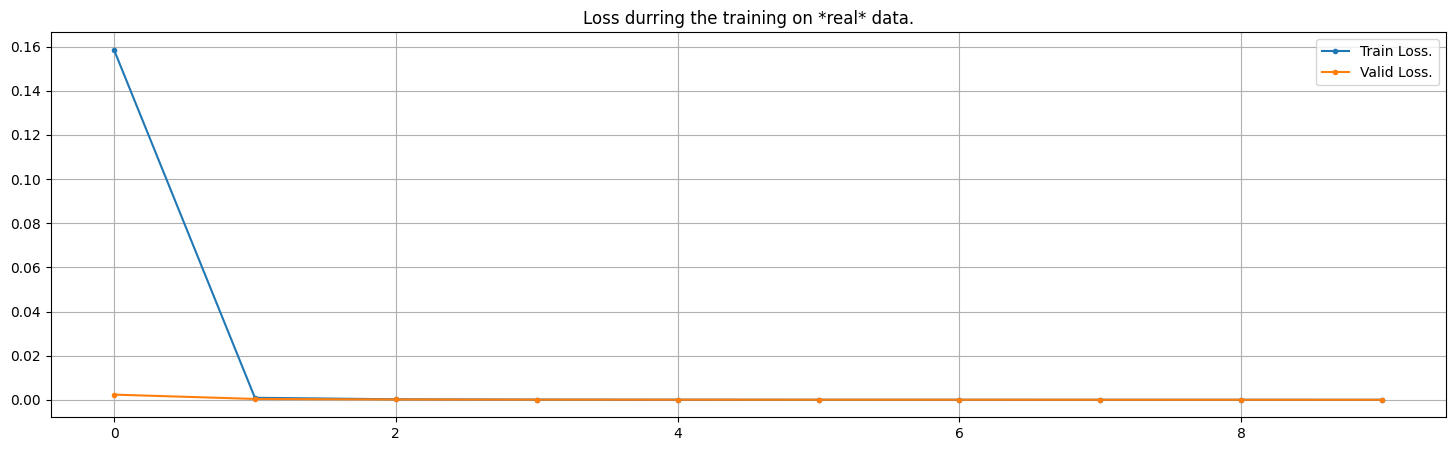

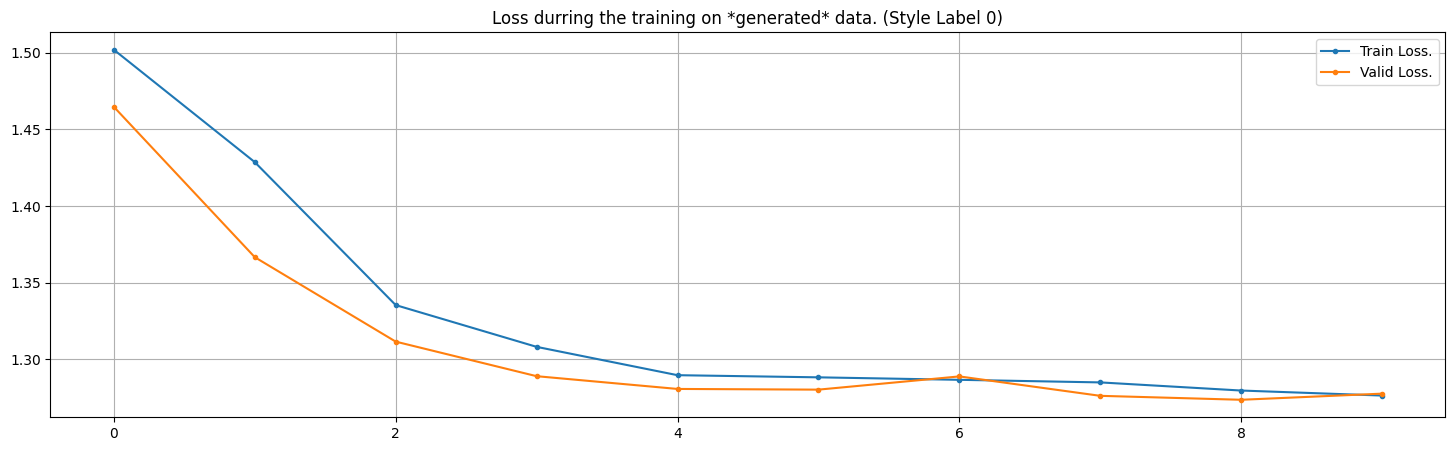

[+] Train on Generated Data.
Epoch 1/10
410/410 [==============================] - 15s 22ms/step - loss: 1.5162 - sparse_categorical_accuracy: 0.2998 - val_loss: 1.4889 - val_sparse_categorical_accuracy: 0.3027
Epoch 2/10
410/410 [==============================] - 14s 22ms/step - loss: 1.4778 - sparse_categorical_accuracy: 0.3084 - val_loss: 1.4544 - val_sparse_categorical_accuracy: 0.3189
Epoch 3/10
410/410 [==============================] - 15s 24ms/step - loss: 1.4197 - sparse_categorical_accuracy: 0.3374 - val_loss: 1.3791 - val_sparse_categorical_accuracy: 0.3610
Epoch 4/10
410/410 [==============================] - 13s 20ms/step - loss: 1.3463 - sparse_categorical_accuracy: 0.3792 - val_loss: 1.3390 - val_sparse_categorical_accuracy: 0.3768
Epoch 5/10
410/410 [==============================] - 14s 22ms/step - loss: 1.3160 - sparse_categorical_accuracy: 0.3837 - val_loss: 1.3012 - val_sparse_categorical_accuracy: 0.3982
Epoch 6/10
410/410 [==============================] - 15s 24m

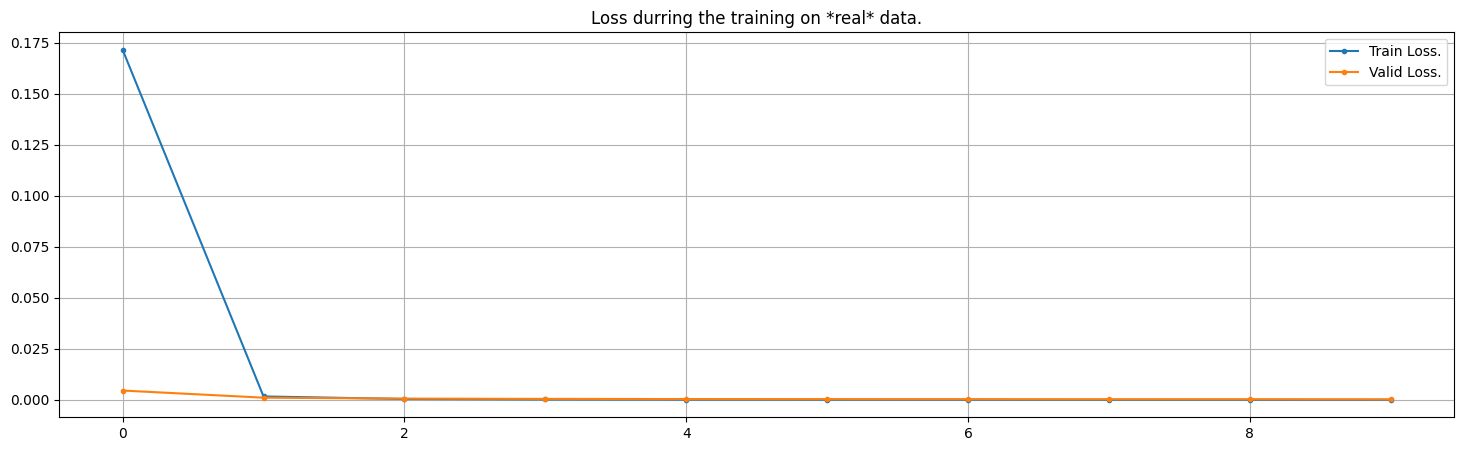

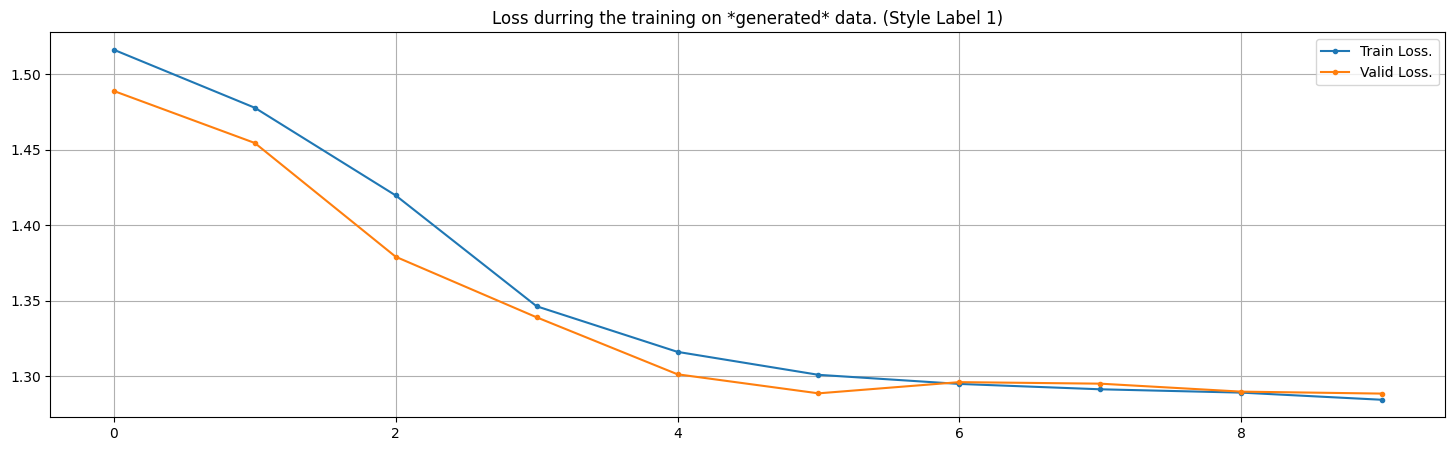

In [76]:
def log_results(folder_to_save:str):
    # Create the folder.
    file_path = f"{folder_to_save}/scores.xlsx"

    style_0_results = tstr_test(0)
    style_1_results = tstr_test(1)

    full_df = pd.concat((style_0_results, style_1_results), ignore_index=True)
    full_df = full_df.set_index(['Style Label'])

    full_df.to_excel(file_path)

log_results(SAVE_FOLDER)